# 0. Imports and Constants

In [95]:
# Basic boilerplate imports
import numpy as np
import pandas as pd
import yaml, os, sys, re
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import uproot
import multiprocessing as mp
import time
import threading
from tqdm.notebook import tqdm
plt.style.use('/sdf/home/b/bearc/sbnd/helpers/sbnd.mplstyle')

#Set paths
SBND_HELPERS_PATH = "/sdf/home/b/bearc/sbnd/helpers/"
SPINE_PATH = "/sdf/home/b/bearc/spine_fmatch/spine/"
sys.path.append(SPINE_PATH)
sys.path.append(SBND_HELPERS_PATH)

#SPINE
from spine.driver import Driver

#SBND
import plotters,makeplot

In [96]:
PLOT_DIR = f'Plots_pgun_studies/Plots_{plotters.day}'

SIM_LABEL = 'Training v01'

BASE_DIR = '/sdf/data/neutrino/bearc/spine/fmatch/validation/'

TEST_DIRS = ['energy','location','angle','particle']

CFG_PATH = 'pgun_studies.cfg'
LARCV_CFG_PATH = 'pgun_studies_larcv.cfg'

LOAD_DF = False

In [97]:
cfg = yaml.safe_load(open(CFG_PATH, 'r'))
print(yaml.dump(cfg))
print('*'*80)
larcv_cfg = yaml.safe_load(open(LARCV_CFG_PATH, 'r'))
print(yaml.dump(larcv_cfg))

build:
  fragments: false
  interactions: true
  mode: both
  particles: true
  units: cm
io:
  reader:
    file_keys:
    - /sdf/data/neutrino/bearc/spine/fmatch/validation/energy/output_spine/*.h5
    - /sdf/data/neutrino/bearc/spine/fmatch/validation/location/output_spine/larcv_spine.h5
    - /sdf/data/neutrino/bearc/spine/fmatch/validation/angle/output_spine/larcv_spine.h5
    - /sdf/data/neutrino/bearc/spine/fmatch/validation/particle/output_spine/*.h5
    name: hdf5

********************************************************************************
io:
  loader:
    batch_size: 10000
    collate_fn: all
    dataset:
      file_keys:
      - /sdf/data/neutrino/bearc/spine/fmatch/validation/energy/larcv/*.root
      - /sdf/data/neutrino/bearc/spine/fmatch/validation/location/larcv/larcv.root
      - /sdf/data/neutrino/bearc/spine/fmatch/validation/angle/larcv/larcv.root
      - /sdf/data/neutrino/bearc/spine/fmatch/validation/particle/larcv/*.root
      name: larcv
      schema:
    

# 1. Helper functions

In [98]:
import os
import csv

def parse_filename(filename):
    """Extract parameters from the filename."""
    # Strip the prefix 'larcv_' and suffix '_spine.h5'
    core_part = filename.replace('larcv_', '').replace('.root','')
    # Split the core part into components based on underscores
    components = core_part.split('_')
    # Extract the parameters and their values
    params = {
        'pdg':int(components[0][3:]),
        'p'  :float(components[1][1:]),
        'x'  :float(components[2][1:]),
        'y'  :float(components[3][1:]),
        'z'  :float(components[4][1:]),
        'thetaxz'  :float(components[5][7:]),
        'thetayz'  :float(components[6][7:]),
        't'  :float(components[7][1:]),
    }
    return params



def write_to_csv(directory, output_csv, start_run):
    """Write the parsed filename parameters to a CSV file."""
    files = [(os.path.join(directory, f), os.path.getmtime(os.path.join(directory, f)))
             for f in os.listdir(directory) if f.endswith('.root') and f.startswith('larcv_')]
    # Sort files by creation time
    files.sort(key=lambda x: x[1])
    # Initialize the CSV file with headers
    with open(output_csv, 'w', newline='') as csvfile:
        fieldnames = ['run', 'filename', 'pdg', 'p', 'x', 'y', 'z', 'thetaxz', 'thetayz', 't']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        # Loop through each file in the directory
        for i,(filepath,_) in enumerate(files):
            filename = os.path.basename(filepath)
            #filename = filepath
            # Parse the filename to get parameters
            params = parse_filename(filename)
            # Prepare the row to be written to CSV
            row = {'run': start_run, 'filename': filepath}
            row.update(params)
            # Write the row to the CSV file
            writer.writerow(row)
            start_run += 1  # Increment the run number for each file

def process_entry(args):
    """
    Process a single entry from the driver with additional arguments.

    Parameters
    ----------
    args : tuple
        A tuple containing the entry index, the driver, and the data dictionary.

    Returns
    -------
    dict
        A dictionary containing processed data for the entry.
    """
    #Dictionary to store 
    data_dict = {
        #Run info
            'run':[],
            'subrun':[],
            'event':[],
        #Particle gun info
            'pdg':[],
            'p'  :[],
            'x'  :[],
            'y'  :[],
            'z'  :[],
            'thetaxz'  :[],
            'thetayz'  :[],
            't'  :[],
        #Flash info
            'true_photons': [],
            'flash_pe': [],
        #Hypothesis info
            'reco_hypo_pe': [],
            'g4_hypo_pe': [],
            'truth_hypo_pe': [],
        #True deposition info
            'g4_depo': [],
            'truth_depo': [],
        #Reco deposition info
            'reco_depo': []
    }

    #Make default dummy dict for malformed data
    _data_dict = data_dict.copy()
    
    entry, driver, df_nphot, reco_log, truth_log = args  # Unpack the arguments
    #Get h5 info
    data = driver.process(entry=entry)
    tps = data['truth_particles']
    rps = data['reco_particles']

    #Run info
    run,subrun,event = data['run_info'].run,data['run_info'].subrun,data['run_info'].event
    data_dict['run'].append(run)
    data_dict['subrun'].append(subrun)
    data_dict['event'].append(event)
    #Info from meta dict
    _run_info = run_info[run_info.run == run]

    #Flash info
    flash_pe = np.sum([f.total_pe for f in data['flash_tpc0']]) +\
               np.sum([f.total_pe for f in data['flash_tpc1']])
    data_dict['flash_pe'].append(flash_pe)

    #Depositions
    g4_depo = np.sum([tp.depositions_g4_sum for tp in tps])
    truth_depo = np.sum([tp.depositions_sum for tp in tps])
    reco_depo = np.sum([rp.depositions_sum for rp in rps])

    data_dict['g4_depo'].append(g4_depo)
    data_dict['truth_depo'].append(truth_depo)
    data_dict['reco_depo'].append(reco_depo)

    #Get parameters of particle gun from larcv_driver
        
    #Get associated run info (parameters of particle gun)
    data_dict['pdg'].append(_run_info.values[0][2])
    data_dict['p'].append(_run_info.values[0][3])
    data_dict['x'].append(_run_info.values[0][4])
    data_dict['y'].append(_run_info.values[0][5])
    data_dict['z'].append(_run_info.values[0][6])
    data_dict['thetaxz'].append(_run_info.values[0][7])
    data_dict['thetayz'].append(_run_info.values[0][8])
    data_dict['t'].append(_run_info.values[0][9])    
    
    #Get total photons
    _df_nphot = df_nphot[(df_nphot['runID'] == run) & (df_nphot['eventID'] == event)]
    if len(_df_nphot) == 0:
        print(f'{opana_fname} has malformed data' + '\n' + f'run {run} event {event} subrun {subrun}')
        return _data_dict
    nphot_tot = _df_nphot['NPhotons'].values[0]
    data_dict['true_photons'].append(nphot_tot)

    #Hypothesis info
    
    #G4 - TODO change this to use g4 info
    # g4_log = pd.read_csv(truth_log_name)
    # _g4_log = g4_log[(g4_log['run'] == run) & (g4_log['subrun'] == subrun) & (g4_log['event'] == event)]
    # g4_hypo_pe = np.sum([h for h in _g4_log['truth_flash_hypo_pe']])
    data_dict['g4_hypo_pe'].append(-999)

    #Truth
    _truth_log = truth_log[(truth_log['run'] == run) & (truth_log['subrun'] == subrun) & (truth_log['event'] == event)]
    truth_hypo_pe = np.sum([h for h in _truth_log['truth_flash_hypo_pe']])
    data_dict['truth_hypo_pe'].append(truth_hypo_pe)

    #Reco 
    _reco_log = reco_log[(reco_log['run'] == run) & (reco_log['subrun'] == subrun) & (reco_log['event'] == event)]
    reco_hypo_pe = np.sum([h for h in _reco_log['reco_flash_hypo_pe']])
    data_dict['reco_hypo_pe'].append(reco_hypo_pe)
    return data_dict

def print_status(interval, stop_event, results_list):
    """
    Print the status of the results list every specified interval until the stop event is set.

    Parameters
    ----------
    interval : int
        Time interval (in seconds) between status updates.
    stop_event : threading.Event
        Event to stop the periodic printing.
    results_list : list
        The list to report the status on.
    """
    while not stop_event.is_set():
        print('Current length of results:', len(results_list))
        time.sleep(interval)
    print('Final length of results:', len(results_list))

def construct_data_csv(driver,df_nphot,truth_interactions,reco_interactions,aggregate=True, num_processes=None):
    """
    Constructs a CSV from data processed in parallel across multiple CPU cores.

    Parameters
    ----------
    driver : object
        The data source driver.
    aggregate : bool, optional
        Whether to aggregate data after processing.
    num_processes : int, optional
        The number of processes to use. If None, uses all available CPUs.

    Returns
    -------
    DataFrame or object
        The processed data as a pandas DataFrame, or an aggregated result if `aggregate` is True.
    """

    if num_processes is None:
        num_processes = mp.cpu_count()

    print('cpu count: ',num_processes)

    args_list = [(i, driver, df_nphot, reco_interactions, truth_interactions) for i in range(len(driver))]

    results = []
    stop_event = threading.Event()
    status_thread = threading.Thread(target=print_status, args=(10, stop_event, results))
    status_thread.start()

    with mp.Pool(num_processes) as pool:
        for result in pool.imap_unordered(process_entry, args_list):
            results.append(result)

    stop_event.set()
    status_thread.join()
    
    # Aggregate all dictionaries into a single DataFrame
    data_df = pd.DataFrame()
    for result in results:
        temp_df = pd.DataFrame(result)
        data_df = pd.concat([data_df, temp_df], ignore_index=True)
    if aggregate:
        return aggregate_data(data_df)
    else:
        return data_df

def aggregate_data(data_df):
    keys = ['run', 'subrun', 'pdg', 'p', 'x', 'y', 'z', 'thetaxz', 'thetayz', 't']
    other_columns = [col for col in data_df.columns if col not in keys]
    
    # Group by the specified keys
    grouped = data_df.groupby(keys)
    
    # Prepare a list to hold the aggregated data
    aggregated_data = []
    
    # Iterate over each group
    for name, group in grouped:
        if not len(group) in [3,5,10]: #Possible number of events  
            print('wtf: ',name, len(group))
        else:
            mean_values = group[other_columns].mean()
            std_values = group[other_columns].std()
    
            # Create a dictionary for the aggregated row
            aggregated_row = {key: val for key, val in zip(keys, name)}
            for col in other_columns:
                aggregated_row[f'{col}_mean'] = mean_values[col]
                aggregated_row[f'{col}_std'] = std_values[col]
    
            # Append the aggregated row to the list
            aggregated_data.append(aggregated_row)
    
    # Create a new DataFrame from the aggregated data
    return pd.DataFrame(aggregated_data)

def process_photdf(opana,prescale=0.152,eff_coatedvuv=0.096,eff_coatedvis=0.104,eff_uncoated=0.152):
    """
    Recompute photon counts to account for efficiency and the prefactor used to scale the photon simulation

    Efficiencies - https://github.com/SBNSoftware/sbndcode/blob/develop/sbndcode/OpDetSim/digi_pmt_sbnd.fcl#L33
    Prescale - https://github.com/SBNSoftware/sbndcode/blob/develop/sbndcode/LArSoftConfigurations/opticalproperties_sbnd.fcl#L33
    
    Parameters
    ----------

    Returns
    ----------
    """

    #First find the number of visible photons on the coated PMT
    opana['NPhotonsPMTCoVIS'] = opana['NPhotons'] - opana['NPhotonsPMTUnco'] - opana['NPhotonsPMTCoVUV']
    
    #Scale by the eff and prefactor
    opana['NPhotonsPMTCoVIS'] *= eff_coatedvis/prescale
    opana['NPhotonsPMTCoVUV'] *= eff_coatedvuv/prescale
    opana['NPhotonsPMTUnco'] *= eff_uncoated/prescale

    #Find the total counts
    opana['NPhotonsPMTCo'] = opana['NPhotonsPMTCoVIS'] + opana['NPhotonsPMTCoVUV']
    opana['NPhotons'] = opana['NPhotonsPMTCoVIS'] + opana['NPhotonsPMTCoVUV'] + opana['NPhotonsPMTUnco']
    return opana

In [99]:
def plot_data(df, x_col, y_cols, y_errs, labels, normalize=False, twin_axis=False, condition=None, title='', xlabel='', ylabels=('Y1', 'Y2'), **kwargs):
    """
    Plots data with optional twin axes and normalization.

    Parameters
    ----------
    df : DataFrame
        The data frame containing the data to plot.
    x_col : str
        The column name for the x-axis values.
    y_cols : list of str
        The column names for the y-axis values.
    y_errs : list of str
        The column names for the y-axis error values.
    labels : list of str
        The labels for each plot.
    normalize : bool, optional
        If True, normalize the y-data to have a maximum of 1.
    twin_axis : bool, optional
        If True, use a twin axis for the second set of y-values.
    condition : array-like, optional
        The condition to filter the data for plotting.
    title : str, optional
        The title of the plot.
    xlabel : str, optional
        The label for the x-axis.
    ylabels : tuple of str, optional
        The labels for the y-axes.
    **kwargs : Plotting options

    Returns
    -------
    fig,ax
    """
    if condition is None:
        condition = [True] * len(df)

    filtered_df = df[condition]
    fig, ax = plt.subplots(figsize=(9, 7))
    axes = [ax]

    if twin_axis:
        ax2 = ax.twinx()
        axes.append(ax2)

    for i, (y_col, y_err, label, style) in enumerate(zip(y_cols, y_errs, labels, styles)):
        y_values = filtered_df[y_col]
        y_errors = filtered_df[y_err]
        if normalize:
            max_val = np.max(y_values)
            y_values = y_values / max_val
            y_errors = y_errors / max_val

        current_ax = axes[i % 2]  # Choose axis based on index if twin_axis is True
        current_ax.errorbar(filtered_df[x_col], y_values, yerr=y_errors, label=label, **kwargs)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabels[0])
    ax.set_title(title)
    if twin_axis:
        ax2.set_ylabel(ylabels[1])

    # Combining legends from both axes
    handles, labels = [], []
    for axis in axes:
        for handle, label in zip(*axis.get_legend_handles_labels()):
            handles.append(handle)
            labels.append(label)

    fig.legend(handles, labels, bbox_to_anchor=(1.3, 0.9), fontsize=14)
    return fig,ax

def plot_data(df, x_col, y_cols, y_errs, labels, colors, y_cols2=None, y_errs2=None, labels2=None, colors2=None, normalize=False, title='', xlabel='', ylabels=('Y1', 'Y2'), **kwargs):
    """
    Plots data with optional twin axes and normalization.

    Parameters
    ----------
    df : DataFrame
        The data frame containing the data to plot.
    x_col : str
        The column name for the x-axis values.
    y_cols : list of str
        The column names for the y-axis values on the primary axis.
    y_errs : list of str
        The column names for the y-axis error values on the primary axis.
    labels : list of str
        The labels for each plot on the primary axis.
    colors : list of str
        Colors for y-axis data.
    colors2 : list of str
        Colors for second y-axis data.
    y_cols2 : list of str, optional
        The column names for the y-axis values on the secondary axis.
    y_errs2 : list of str, optional
        The column names for the y-axis error values on the secondary axis.
    labels2 : list of str, optional
        The labels for each plot on the secondary axis.
    styles2 : list of dict, optional
        The style for each plot on the secondary axis.
    normalize : bool, optional
        If True, normalize the y-data to have a maximum of 1.
    title : str, optional
        The title of the plot.
    xlabel : str, optional
        The label for the x-axis.
    ylabels : tuple of str, optional
        The labels for the y-axes.

    Returns
    -------
    fig, ax
    """
    fig, ax = plt.subplots(figsize=(9, 7))
    axes = [ax]

    if y_cols2:
        ax2 = ax.twinx()
        axes.append(ax2)

    # Plotting on primary axis
    for y_col, y_err, label, c in zip(y_cols, y_errs, labels, colors):
        y_values = df[y_col]
        y_errors = df[y_err]
        if normalize:
            max_val = np.max(y_values)
            y_values = y_values / max_val
            if y_err:
                y_errors = y_errors / max_val
        ax.errorbar(df[x_col], y_values, yerr=y_errors, label=label, color=c, **kwargs)

    # Plotting on secondary axis if applicable
    if y_cols2:
        for y_col, y_err, label, c in zip(y_cols2, y_errs2, labels2, colors2):
            y_values = df[y_col]
            y_errors = df[y_err]
            if normalize:
                max_val = np.max(y_values)
                y_values = y_values / max_val
                y_errors = y_errors / max_val
            ax2.errorbar(df[x_col], y_values, yerr=y_errors, label=label, ls='--', color=c, **kwargs)
        ax2.set_ylabel(ylabels[1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabels[0])
    ax.set_title(title)

    # Combining legends from both axes
    handles, labels = [], []
    for axis in axes:
        for handle, label in zip(*axis.get_legend_handles_labels()):
            handles.append(handle)
            labels.append(label)

    fig.legend(handles, labels, bbox_to_anchor=(1.3, 0.9), fontsize=14)

    return fig,axes
def plot_configurations(df, x_col, y_cols, y_errs, labels, colors, fname, y_cols2, y_errs2, labels2, colors2, title,
                        xlabel, ylabels, ylims, ylims2, fname2, folder_name=PLOT_DIR+'/temp', save=True, close=True, norms=[True,False],
                        fname_suffix = '',**kwargs):
    """
    Plot data with various configurations based on the provided parameters.

    Parameters
    ----------
    df : DataFrame
        Data containing the energy information.
    x_col : str
        Column name for the x-axis.
    y_cols : list of str
        Column names for y-axis data.
    y_errs : list of str
        Column names for the standard deviations of the y-axis data.
    labels : list of str
        Labels for the y-axis data.
    colors : list of str
        Colors for y-axis data.
    fname: str
        filename of first dataset
    y_cols2 : list of str
        Column names for the second set of y-axis data.
    y_errs2 : list of str
        Column names for the standard deviations of the second set of y-axis data.
    labels2 : list of str
        Labels for the second set of y-axis data.
    colors2 : list of str
        Colors for second y-axis data.
    fname: str
        filename of second dataset
    title : str
        Title of the plot.
    xlabel : str
        Label for the x-axis.
    ylabels : tuple of str
        Labels for the y-axes.
    ylims : list
        Y-axis limits for the first set of plots.
    ylims2 : list
        Y-axis limits for the second set of plots.
    folder_name: str
        Folder to save to
    save : bool
        Save plot
    close : bool
        Close plot
    norms : list of bool
        Normalization bools

    Returns
    -------
    None
    """
    for norm in norms:
        for use_depo in [True, False]:
            for use_light in [True, False]:
                #Clear
                _fname = ''

                #find plot config to use
                if use_depo and use_light:
                    _y_cols, _y_errs, _y_cols2, _y_errs2 = y_cols, y_errs, y_cols2, y_errs2
                    _labels, _labels2, _ylabels = labels, labels2, ylabels
                    _colors, _colors2 = colors, colors2
                    _ylims, _ylims2 = ylims, ylims2
                    _fname = f'{fname}_{fname2}'
                elif use_depo and not use_light:
                    _y_cols, _y_errs, _y_cols2, _y_errs2 = y_cols2, y_errs2, None, None
                    _labels, _labels2, _ylabels = labels2, None, (ylabels[1], '')
                    _ylims, _ylims2 = ylims2, None
                    _colors, _colors2 = colors2, None
                    _fname = fname2
                elif not use_depo and use_light:
                    _y_cols, _y_errs, _y_cols2, _y_errs2 = y_cols, y_errs, None, None
                    _labels, _labels2, _ylabels = labels, None, ylabels
                    _ylims, _ylims2 = ylims, None
                    _colors, _colors2 = colors, None
                    _fname = fname
                else:
                    continue

                if norm:
                    _fname += '_norm'
                    _ylabels = [y + ' (normalized)' for y in _ylabels]
                    _ylims = [0, 1.2]
                    _ylims2 = [0, 1.2] if _ylims2 else None

                #Make those plots
                fig, axes = plot_data(df, x_col, _y_cols, _y_errs, _labels, _colors, y_cols2=_y_cols2, y_errs2=_y_errs2,
                                      labels2=_labels2, colors2=_colors2, normalize=norm, title=title, xlabel=xlabel, ylabels=_ylabels,
                                      **kwargs)

                #set axes limits
                for i, ax in enumerate(axes):
                    if i == 0:
                        __ylims = _ylims
                    elif i == 1:
                        __ylims = _ylims2
                    else:
                        raise Exception('More than 2 axes wtf')
                    ax.set_ylim(__ylims)

                #Save / close
                _fname += fname_suffix
                if save:
                    plotters.save_plot(_fname, folder_name=folder_name)
                    #print(f'saved {_fname}.png to {folder_name}')
                if close:
                    plt.close('all')

# 2. Construct meta data needed

In [116]:
if LOAD_DF:
    run_info = pd.read_csv(f'{BASE_DIR}/simulation_log.csv')
else:
    # Make csvs containing meta data mapping to 
    dfs = []
    start_values = [1,1000,2000,3000]
    for i,path in enumerate(TEST_DIRS):
        if os.path.exists(f'{BASE_DIR}{path}/simulation_log.csv'):
            dfs.append(pd.read_csv(f'{BASE_DIR}{path}/simulation_log.csv'))
        else:
            dir_path = BASE_DIR + path + '/larcv/'
            output_csv_path = BASE_DIR + path + '/run_map.csv'
            write_to_csv(dir_path, output_csv_path, start_values[i])
            dfs.append(pd.read_csv(output_csv_path))
    run_info = pd.concat(dfs)
    run_info.to_csv(f'{BASE_DIR}/simulation_log.csv')

In [117]:
run_info.head()

,run,filename,pdg,p,x,y,z,thetaxz,thetayz,t,n
0,1,/sdf/data/neutrino/bearc/spine/fmatch/validati...,13,0.1,-100.0,0.0,-10.0,0.0,0.0,0.0,NaN
1,2,/sdf/data/neutrino/bearc/spine/fmatch/validati...,13,0.2,-100.0,0.0,-10.0,0.0,0.0,0.0,NaN
2,3,/sdf/data/neutrino/bearc/spine/fmatch/validati...,13,0.3,-100.0,0.0,-10.0,0.0,0.0,0.0,NaN
3,4,/sdf/data/neutrino/bearc/spine/fmatch/validati...,13,0.4,-100.0,0.0,-10.0,0.0,0.0,0.0,NaN
4,5,/sdf/data/neutrino/bearc/spine/fmatch/validati...,13,0.5,-100.0,0.0,-10.0,0.0,0.0,0.0,NaN


In [118]:
#Get truth photon info
opana_fname = BASE_DIR + 'opana_all.root'
tree_opana = uproot.open(opana_fname)['opanatree/OpAnaTree;1']
#Manully get keys for different trees - constant so no need to redefine
keys_opana_run = ['eventID','runID','subrunID']
keys_opana_ntot = [k for k in tree_opana.keys() if 'NPhoton' in k]
#Data frame with info
df_nphot = tree_opana.arrays(keys_opana_ntot + keys_opana_run,library='pd')
df_nphot.drop_duplicates(inplace=True)
#Process to account for eff.
df_nphot = process_photdf(df_nphot)
df_nphot

,NPhotons,NPhotonsPMTCo,NPhotonsPMTUnco,NPhotonsPMTCoVUV,NPhotonsXARAPUCAVUV,NPhotonsXARAPUCAVIS,eventID,runID,subrunID,NPhotonsPMTCoVIS
0,2741.684211,2456.684211,285.0,1645.894737,0,0,1,1,0,810.789474
1,1994.947368,1815.947368,179.0,1239.157895,0,0,2,1,0,576.789474
2,2024.052632,1832.052632,192.0,1251.157895,0,0,3,1,0,580.894737
3,3137.000000,2808.000000,329.0,1863.789474,0,0,4,1,0,944.210526
4,2058.842105,1832.842105,226.0,1249.894737,0,0,5,1,0,582.947368
...,...,...,...,...,...,...,...,...,...,...
2328,74834.157895,66331.157895,8503.0,43068.000000,0,0,6,3001,0,23263.157895
2329,72695.210526,64739.210526,7956.0,42285.473684,0,0,7,3001,0,22453.736842
2330,78056.736842,69155.736842,8901.0,44897.052632,0,0,8,3001,0,24258.684211
2331,73689.421053,65478.421053,8211.0,43152.631579,0,0,9,3001,0,22325.789474


In [121]:
#Get interactions from logs - contains flashes
truth_interactions = pd.read_csv(BASE_DIR + 'truth_interactions.csv')
reco_interactions = pd.read_csv(BASE_DIR + 'reco_interactions.csv')
len(truth_interactions),len(reco_interactions)

(2190, 2298)

In [122]:
_driver = Driver(cfg)


 ██████████   ██████████    ███   ███       ██   ███████████
███        █  ██       ███   █    █████     ██   ██         
  ████████    ██       ███  ███   ██  ████  ██   ██████████ 
█        ███  ██████████     █    ██     █████   ██         
 ██████████   ██            ███   ██       ███   ███████████

Release version: 0.1.0

$CUDA_VISIBLE_DEVICES=

Configuration processed at: Linux sdfampere019 4.18.0-372.32.1.el8_6.x86_64 #1 SMP Fri Oct 7 12:35:10 EDT 2022 x86_64 x86_64 x86_64 GNU/Linux

base: {seed: 1728418356}
io:
  reader:
    file_keys: [/sdf/data/neutrino/bearc/spine/fmatch/validation/energy/output_spine/*.h5,
      /sdf/data/neutrino/bearc/spine/fmatch/validation/location/output_spine/larcv_spine.h5,
      /sdf/data/neutrino/bearc/spine/fmatch/validation/angle/output_spine/larcv_spine.h5,
      /sdf/data/neutrino/bearc/spine/fmatch/validation/particle/output_spine/*.h5]
    name: hdf5
build: {fragments: false, interactions: true, mode: both, particles: true, units: cm}

Will

# 3. Construct analysis dataframes

In [123]:
if LOAD_DF:
#if False:
    df = pd.read_csv(BASE_DIR+'aggregate_df.csv')
else:
    df = construct_data_csv(_driver,df_nphot,truth_interactions,reco_interactions,num_processes=None,aggregate=True)

    # Calculate ratios and their errors
    df['flash_to_true_photon_ratio'] = df['flash_pe_mean'] / df['true_photons_mean']
    df['flash_to_true_photon_ratio_err'] = df['flash_pe_std'] / df['true_photons_mean']

    df['truth_hypo_to_true_photon_ratio'] = df['truth_hypo_pe_mean'] / df['true_photons_mean']
    df['truth_hypo_to_true_photon_ratio_err'] = df['truth_hypo_pe_std'] / df['true_photons_mean']

    df['reco_hypo_to_true_photon_ratio'] = df['reco_hypo_pe_mean'] / df['true_photons_mean']
    df['reco_hypo_to_true_photon_ratio_err'] = df['reco_hypo_pe_std'] / df['true_photons_mean']

    df['truth_depo_to_g4_ratio'] = df['truth_depo_mean'] / df['g4_depo_mean']
    df['truth_depo_to_g4_ratio_err'] = df['truth_depo_std'] / df['g4_depo_mean']

    df['reco_depo_to_g4_ratio'] = df['reco_depo_mean'] / df['g4_depo_mean']
    df['reco_depo_to_g4_ratio_err'] = df['reco_depo_std'] / df['g4_depo_mean']

    # Calculate errors
    df['error_flash'] = (df['flash_pe_mean'] - df['true_photons_mean']) / df['true_photons_mean']
    df['error_truth_hypo'] = (df['truth_hypo_pe_mean'] - df['true_photons_mean']) / df['true_photons_mean']
    df['error_reco_hypo'] = (df['reco_hypo_pe_mean'] - df['true_photons_mean']) / df['true_photons_mean']
    df['error_truth_hypo_flash'] = (df['truth_hypo_pe_mean'] - df['flash_pe_mean']) / df['flash_pe_mean']
    df['error_reco_hypo_flash'] = (df['reco_hypo_pe_mean'] - df['flash_pe_mean']) / df['flash_pe_mean']
    df['dummy_err'] = 0 #dumby error for when you don't want error bars
    df['error_truth_hypo_flash'] =  (df['truth_hypo_pe_mean'] - df['flash_pe_mean']) / df['flash_pe_mean']
    df['error_reco_hypo_flash'] =  (df['reco_hypo_pe_mean'] - df['flash_pe_mean']) / df['flash_pe_mean']
    
    df['error_truth_depo'] = (df['truth_depo_mean'] - df['g4_depo_mean']) / df['g4_depo_mean']
    df['error_reco_depo'] = (df['reco_depo_mean'] - df['g4_depo_mean']) / df['g4_depo_mean']
    
    df.to_csv(BASE_DIR+'aggregate_df.csv')

cpu count:  128
Current length of results: 0
Current length of results: 674
Current length of results: 1873
Final length of results: 2188


In [124]:
energy_df = df[df.run < 1000]
location_df = df[(df.run >= 1000) & (df.run < 2000)]
angle_df = df[(df.run >= 2000) & (df.run < 3000)]
particle_df = df[(df.run >= 3000) & (df.run < 4000)]

In [125]:
energy_df

,run,subrun,pdg,p,x,y,z,thetaxz,thetayz,t,...,reco_depo_to_g4_ratio,reco_depo_to_g4_ratio_err,error_flash,error_truth_hypo,error_reco_hypo,error_truth_hypo_flash,error_reco_hypo_flash,dummy_err,error_truth_depo,error_reco_depo
0,2,0,13,0.2,-100.0,0.0,-10.0,0.0,0.0,0.0,...,0.783808,0.177584,-0.044622,-0.376237,-0.475133,-0.347103,-0.450619,0,-0.073453,-0.216192
1,3,0,13,0.3,-100.0,0.0,-10.0,0.0,0.0,0.0,...,0.913292,0.022462,-0.038299,-0.263540,-0.348041,-0.234211,-0.322077,0,0.024929,-0.086708
2,4,0,13,0.4,-100.0,0.0,-10.0,0.0,0.0,0.0,...,0.936756,0.047484,-0.034187,-0.083529,-0.177173,-0.051089,-0.148048,0,0.035654,-0.063244
3,5,0,13,0.5,-100.0,0.0,-10.0,0.0,0.0,0.0,...,0.943108,0.052195,-0.027839,-0.052848,-0.137855,-0.025725,-0.113167,0,0.029344,-0.056892
4,6,0,13,0.6,-100.0,0.0,-10.0,0.0,0.0,0.0,...,0.961535,0.017104,-0.028235,-0.056201,-0.143563,-0.028779,-0.118679,0,0.054484,-0.038465
5,7,0,13,0.7,-100.0,0.0,-10.0,0.0,0.0,0.0,...,0.980130,0.021501,-0.025391,-0.046588,-0.134666,-0.021749,-0.112122,0,0.074519,-0.019870
6,8,0,13,0.8,-100.0,0.0,-10.0,0.0,0.0,0.0,...,0.962045,0.030411,-0.023246,-0.026570,-0.101266,-0.003403,-0.079877,0,0.038203,-0.037955
7,9,0,13,0.9,-100.0,0.0,-10.0,0.0,0.0,0.0,...,0.989434,0.013605,-0.018152,-0.032213,-0.103932,-0.014320,-0.087365,0,0.065240,-0.010566
8,10,0,13,1.0,-100.0,0.0,-10.0,0.0,0.0,0.0,...,0.990231,0.022107,-0.019753,-0.001553,-0.087653,0.018567,-0.069268,0,0.081449,-0.009769
9,11,0,13,1.1,-100.0,0.0,-10.0,0.0,0.0,0.0,...,0.975149,0.010438,-0.018554,-0.014167,-0.078818,0.004470,-0.061404,0,0.042355,-0.024851


In [126]:
location_df

,run,subrun,pdg,p,x,y,z,thetaxz,thetayz,t,...,reco_depo_to_g4_ratio,reco_depo_to_g4_ratio_err,error_flash,error_truth_hypo,error_reco_hypo,error_truth_hypo_flash,error_reco_hypo_flash,dummy_err,error_truth_depo,error_reco_depo
19,1001,0,13,1.0,-190.0,210.0,10.0,0.0,-90.0,0.0,...,0.912478,0.341826,-0.628212,-0.207801,-0.252465,1.130779,1.010647,0,-0.080464,-0.087522
20,1002,0,13,1.0,-190.0,210.0,30.0,0.0,-90.0,0.0,...,1.059705,0.032456,-0.590726,-0.009728,0.000017,1.419583,1.443392,0,0.051037,0.059705
21,1003,0,13,1.0,-190.0,210.0,50.0,0.0,-90.0,0.0,...,1.051717,0.218132,-0.551036,-0.259073,-0.335776,0.650303,0.479457,0,0.049827,0.051717
22,1004,0,13,1.0,-190.0,210.0,70.0,0.0,-90.0,0.0,...,1.082717,0.459669,-0.545151,-0.287225,-0.277542,0.567057,0.588346,0,0.072626,0.082717
23,1005,0,13,1.0,-190.0,210.0,90.0,0.0,-90.0,0.0,...,1.075267,0.015455,-0.485106,-0.018983,-0.013754,0.905281,0.915436,0,0.069953,0.075267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,1496,0,13,1.0,190.0,210.0,410.0,0.0,-90.0,0.0,...,1.082878,0.386900,-0.647460,-0.392064,-0.372843,0.724445,0.778969,0,0.058383,0.082878
515,1497,0,13,1.0,190.0,210.0,430.0,0.0,-90.0,0.0,...,1.043142,0.025847,-0.392160,-0.018051,-0.004609,0.615473,0.637588,0,0.044767,0.043142
516,1498,0,13,1.0,190.0,210.0,450.0,0.0,-90.0,0.0,...,1.078891,0.177479,-0.458011,-0.484049,-0.463452,-0.048040,-0.010039,0,0.039927,0.078891
517,1499,0,13,1.0,190.0,210.0,470.0,0.0,-90.0,0.0,...,1.052193,0.063079,-0.716873,-0.032999,-0.008064,2.415434,2.503503,0,0.024583,0.052193


In [127]:
angle_df

,run,subrun,pdg,p,x,y,z,thetaxz,thetayz,t,...,reco_depo_to_g4_ratio,reco_depo_to_g4_ratio_err,error_flash,error_truth_hypo,error_reco_hypo,error_truth_hypo_flash,error_reco_hypo_flash,dummy_err,error_truth_depo,error_reco_depo
519,2001,0,13,1.0,-100.0,0.0,10.0,-90.0,-90.0,0.0,...,0.982462,0.042363,-0.026829,-0.080092,-0.089636,-0.054731,-0.064539,0,-0.005999,-0.017538
520,2002,0,13,1.0,-100.0,0.0,10.0,-90.0,-70.0,0.0,...,1.062306,0.033637,-0.039430,-0.022055,-0.063555,0.018088,-0.025116,0,0.108941,0.062306
521,2003,0,13,1.0,-100.0,0.0,10.0,-90.0,-50.0,0.0,...,0.981635,0.296395,-0.244121,-0.362661,-0.385688,-0.156824,-0.187287,0,0.020949,-0.018365
522,2004,0,13,1.0,-100.0,0.0,10.0,-90.0,-30.0,0.0,...,0.975222,0.110308,-0.304559,-0.370098,-0.377479,-0.094240,-0.104854,0,-0.008501,-0.024778
523,2005,0,13,1.0,-100.0,0.0,10.0,-90.0,-10.0,0.0,...,0.940376,0.059162,-0.203007,-0.465025,-0.473577,-0.328758,-0.339488,0,-0.035702,-0.059624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,2178,0,13,1.0,-100.0,0.0,10.0,80.0,0.0,0.0,...,0.737172,0.196296,-0.031448,-0.345597,-0.434692,-0.324349,-0.416337,0,-0.136402,-0.262828
696,2179,0,13,1.0,-100.0,0.0,10.0,80.0,20.0,0.0,...,1.035855,0.007632,-0.095232,-0.202974,-0.224496,-0.119082,-0.142870,0,0.069916,0.035855
697,2180,0,13,1.0,-100.0,0.0,10.0,80.0,40.0,0.0,...,1.026776,0.089364,-0.020550,-0.024781,-0.107100,-0.004320,-0.088366,0,0.110902,0.026776
698,2181,0,13,1.0,-100.0,0.0,10.0,80.0,60.0,0.0,...,1.033352,0.005203,-0.024272,0.024699,-0.068054,0.050189,-0.044872,0,0.134167,0.033352


In [128]:
particle_df

,run,subrun,pdg,p,x,y,z,thetaxz,thetayz,t,...,reco_depo_to_g4_ratio,reco_depo_to_g4_ratio_err,error_flash,error_truth_hypo,error_reco_hypo,error_truth_hypo_flash,error_reco_hypo_flash,dummy_err,error_truth_depo,error_reco_depo
700,3000,0,13,1.0,-100.0,0.0,0.0,0.0,0.0,0.0,...,0.998804,0.020536,-0.017032,0.008150,-0.071211,0.025618,-0.055118,0,0.081192,-0.001196
701,3001,0,22,1.0,-100.0,0.0,0.0,0.0,0.0,0.0,...,0.669920,0.027092,-0.029569,-0.223561,-0.326767,-0.199903,-0.306254,0,-0.232719,-0.330080
702,3002,0,11,1.0,-100.0,0.0,0.0,0.0,0.0,0.0,...,0.660691,0.044609,-0.031325,-0.239644,-0.333258,-0.215056,-0.311697,0,-0.246273,-0.339309
703,3003,0,211,1.0,-100.0,0.0,0.0,0.0,0.0,0.0,...,0.726207,0.212796,-0.090645,-0.386834,-0.537022,-0.325714,-0.490872,0,-0.045679,-0.273793
704,3004,0,2212,1.0,-100.0,0.0,0.0,0.0,0.0,0.0,...,0.705547,0.180984,-0.034200,-0.286429,-0.467501,-0.261160,-0.448645,0,-0.072829,-0.294453


# 4. Energy

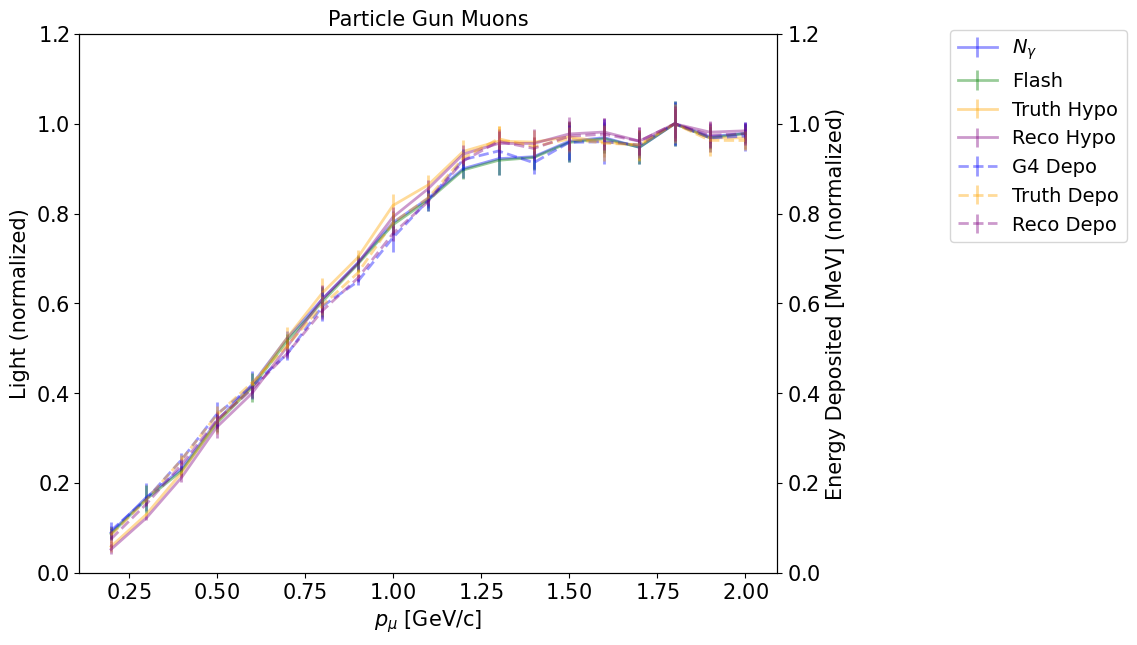

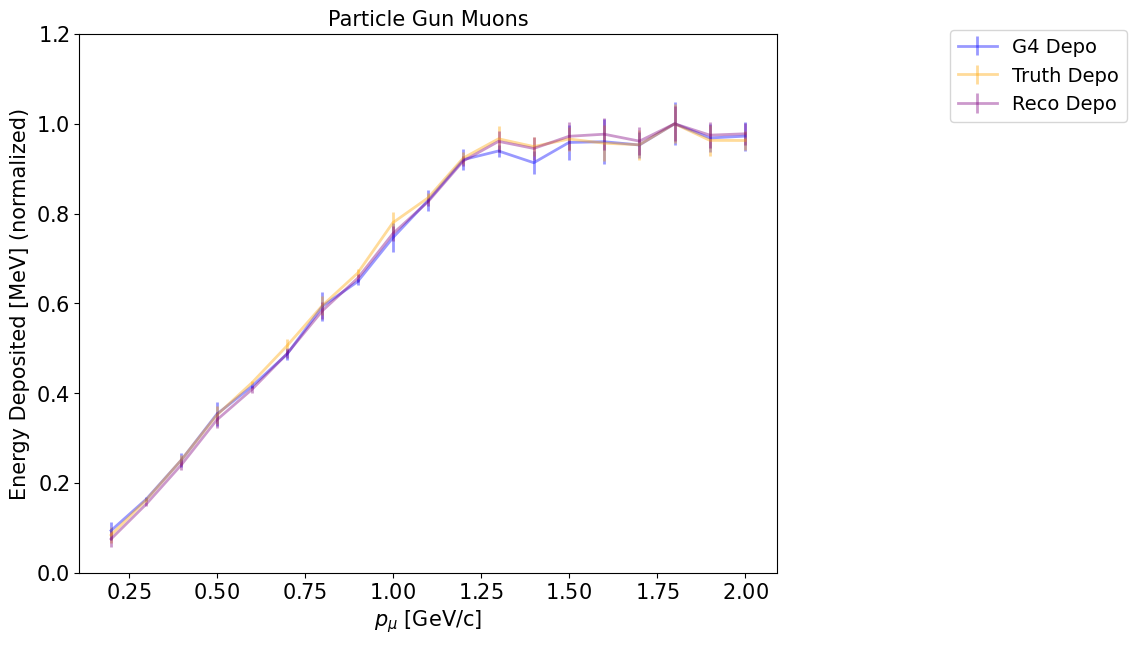

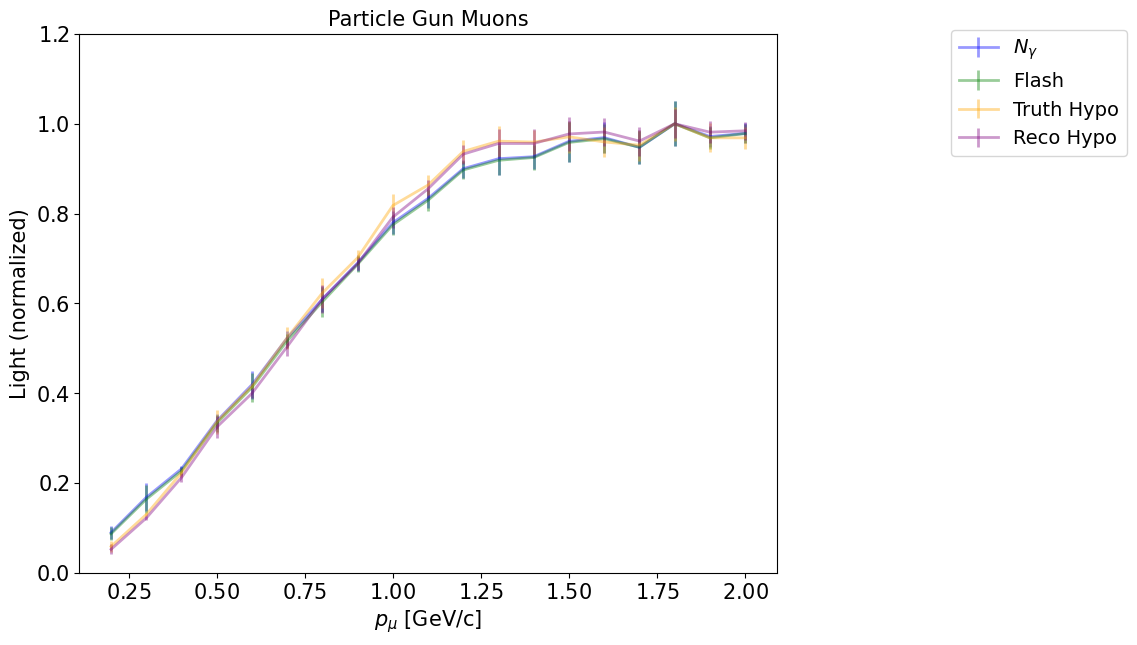

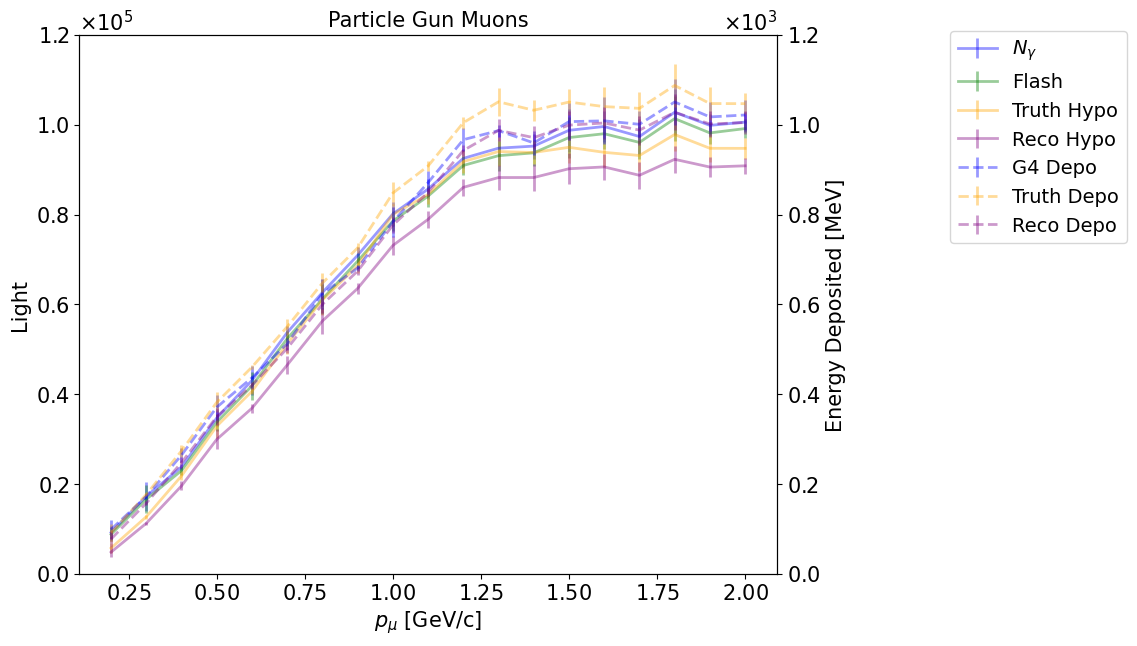

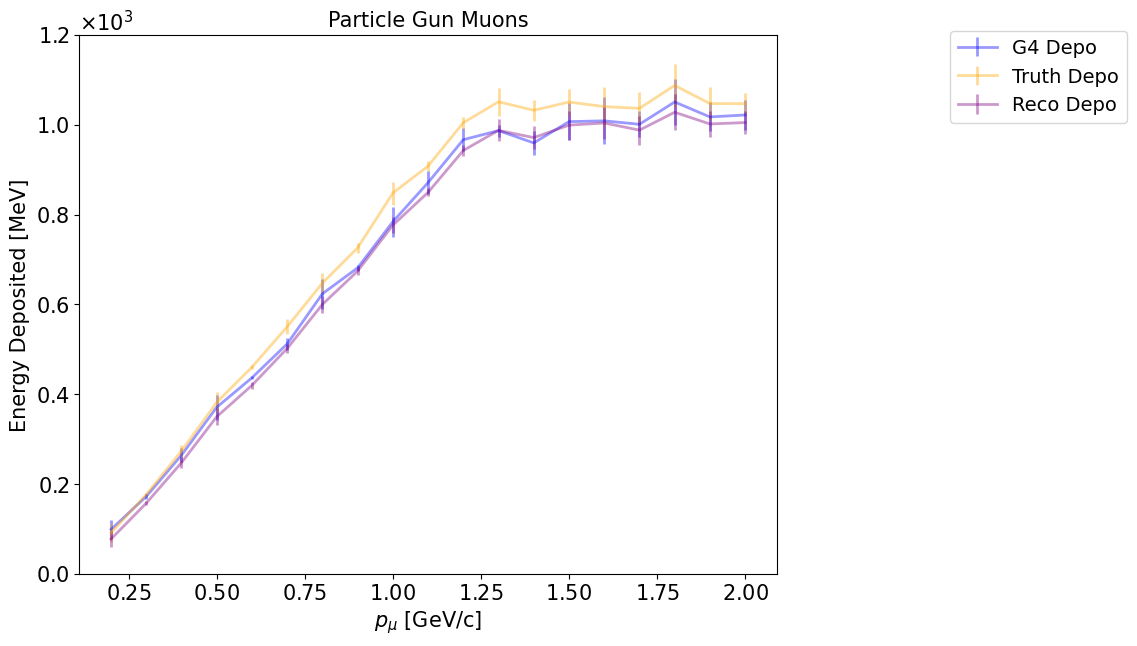

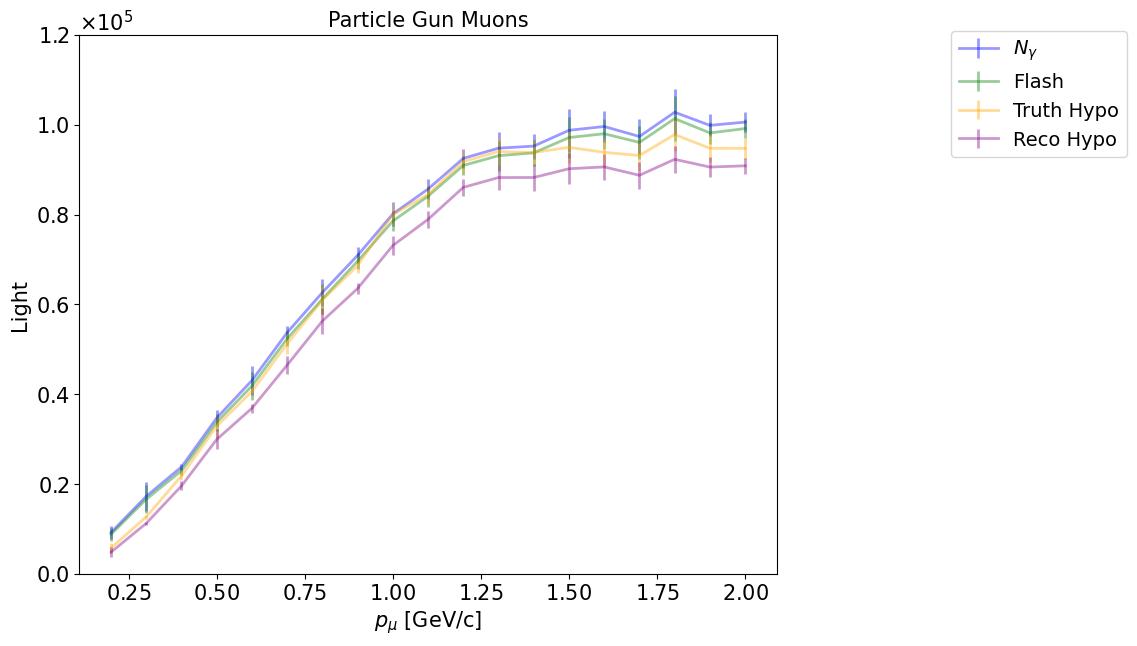

In [129]:
#What to plot
fname = 'light'
x_col = 'p'
y_cols = ['true_photons_mean','flash_pe_mean','truth_hypo_pe_mean','reco_hypo_pe_mean']
y_errs = ['true_photons_std','flash_pe_std','truth_hypo_pe_std','reco_hypo_pe_std']
labels = [r'$N_\gamma$', 'Flash', 'Truth Hypo', 'Reco Hypo']
colors = ['blue','green','orange','purple']

fname2 = 'depo'
y_cols2 = ['g4_depo_mean','truth_depo_mean','reco_depo_mean']
y_errs2 = ['g4_depo_std','truth_depo_std','reco_depo_std']
labels2 = ['G4 Depo','Truth Depo','Reco Depo']
colors2 = ['blue','orange','purple']

#Labels
title = 'Particle Gun Muons'
xlabel = r'$p_\mu$ [GeV/c]'
ylabels = ('Light','Energy Deposited [MeV]')

#kwargs
alpha = 0.4
lw = 2

#ax config
ylims = [0,1.2e5]
ylims2 = [0,1200]

#Save config
folder_name = PLOT_DIR+'/energy/linear'

plot_configurations(energy_df, x_col, y_cols, y_errs, labels, colors, fname, y_cols2, y_errs2, labels2, colors2, title,
                        xlabel, ylabels, ylims, ylims2, fname2, folder_name=folder_name, save=True, close=False, alpha=alpha,lw=lw)

In [130]:
#What to plot
x_col = 'p'
y_cols = ['flash_to_true_photon_ratio','truth_hypo_to_true_photon_ratio','reco_hypo_to_true_photon_ratio']
y_errs = ['flash_to_true_photon_ratio_err','truth_hypo_to_true_photon_ratio_err','reco_hypo_to_true_photon_ratio_err']
labels = [r'Flash/$N_\gamma$', r'Truth Hypo/$N_\gamma$', r'Reco Hypo/$N_\gamma$']
colors = ['green','orange','purple']

y_cols2 = ['truth_depo_to_g4_ratio','reco_depo_to_g4_ratio']
y_errs2 = ['truth_depo_to_g4_ratio_err','reco_depo_to_g4_ratio_err']
labels2 = ['Truth/G4','Reco/G4']
colors2 = ['orange','purple']

#Labels
title = 'Particle Gun Muons'
xlabel = r'$p_\mu$ [GeV/c]'
ylabels = ('Light','Energy Deposited [MeV]')

#kwargs
alpha = 0.4
lw = 2

#ax config
ylims = [0,1.2]
ylims2 = [0,1.2]

#Save config
folder_name = PLOT_DIR+'/energy/ratio'

plot_configurations(energy_df, x_col, y_cols, y_errs, labels, colors, fname, y_cols2, y_errs2, labels2, colors2, title,
                        xlabel, ylabels, ylims, ylims2, fname2, folder_name=folder_name, save=True, close=True, alpha=alpha,lw=lw)

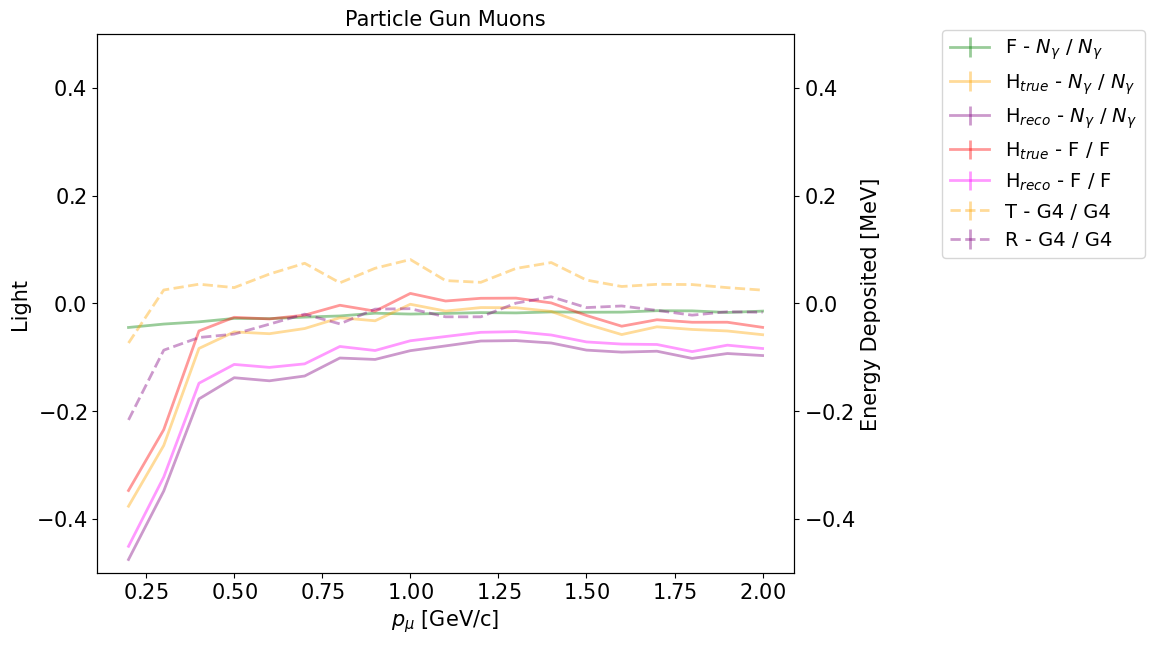

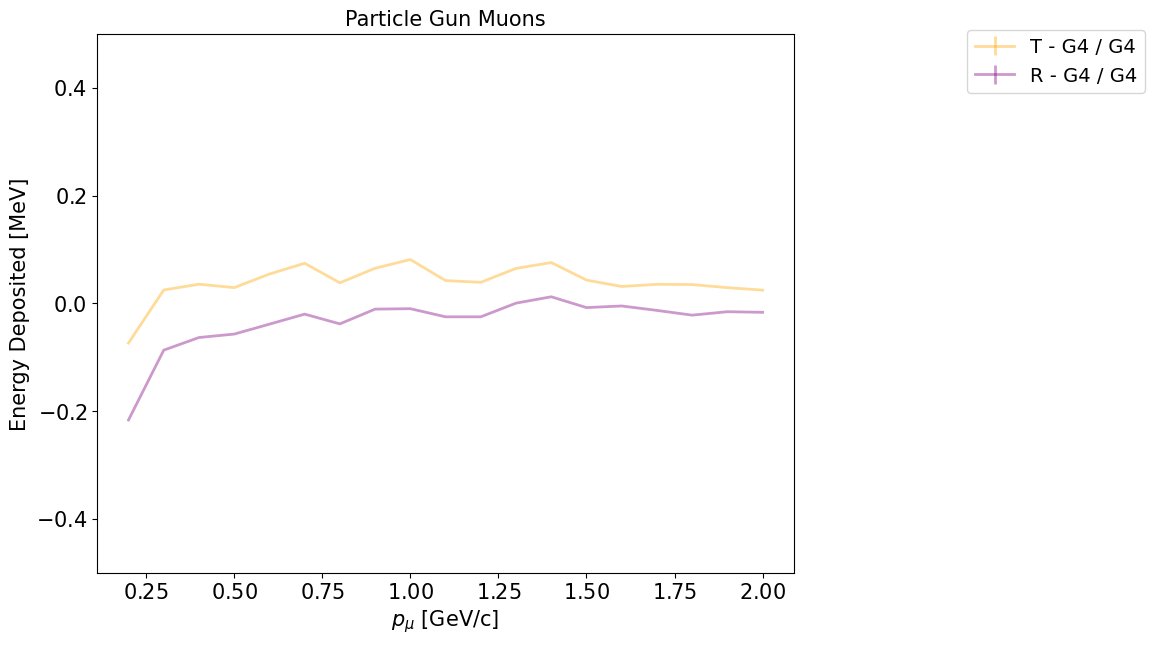

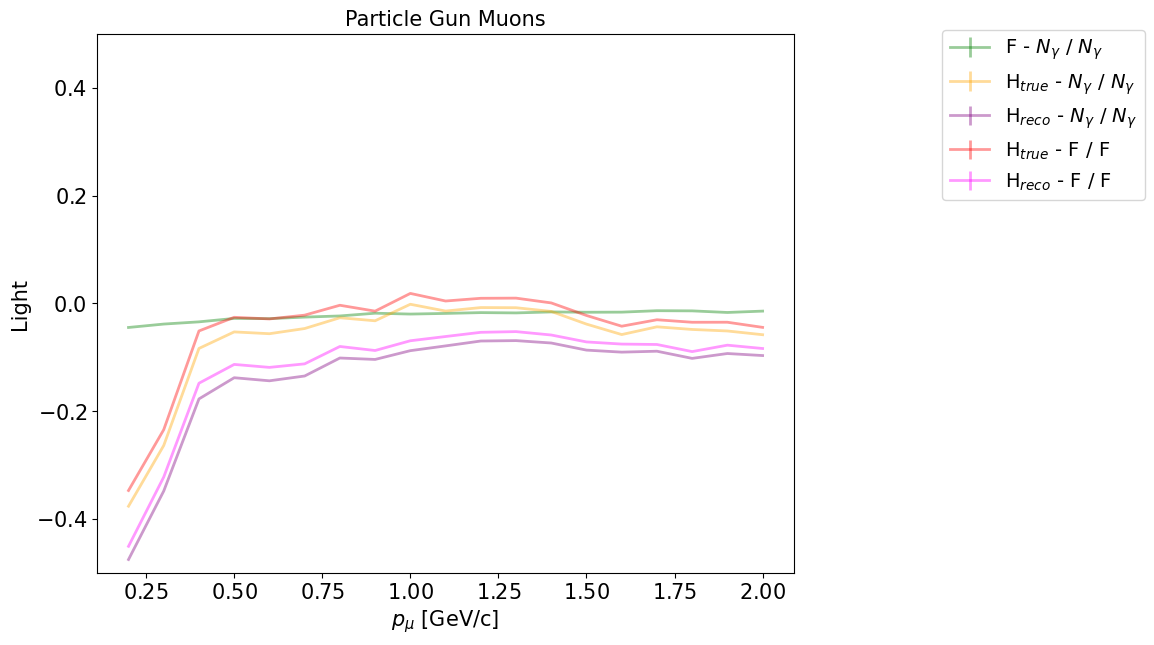

In [131]:
#What to plot
x_col = 'p'
y_cols = ['error_flash','error_truth_hypo','error_reco_hypo','error_truth_hypo_flash','error_reco_hypo_flash']
y_errs = ['dummy_err']*len(y_cols)
labels = [r'F - $N_\gamma$ / $N_\gamma$', r'H$_{true}$ - $N_\gamma$ / $N_\gamma$', r'H$_{reco}$ - $N_\gamma$ / $N_\gamma$',r'H$_{true}$ - F / F', r'H$_{reco}$ - F / F']
colors = ['green','orange','purple','red','magenta']

y_cols2 = ['error_truth_depo','error_reco_depo']
y_errs2 = ['dummy_err']*2
labels2 = [r'T - G4 / G4','R - G4 / G4']
colors2 = ['orange','purple']

#Labels
title = 'Particle Gun Muons'
xlabel = r'$p_\mu$ [GeV/c]'
ylabels = ('Light','Energy Deposited [MeV]')

#kwargs
alpha = 0.4
lw = 2
norms = [False]

#ax config
ylims = [-0.5,0.5]
ylims2 = [-0.5,0.5]

#Save config
folder_name = PLOT_DIR+'/energy/error'
plot_configurations(energy_df, x_col, y_cols, y_errs, labels, colors, fname, y_cols2, y_errs2, labels2, colors2, title,
                        xlabel, ylabels, ylims, ylims2, fname2, folder_name=folder_name, save=True, close=False, norms=norms, alpha=alpha,lw=lw)

# 5. Location

In [49]:
location_df.keys()

Index(['run', 'subrun', 'pdg', 'p', 'x', 'y', 'z', 'thetaxz', 'thetayz', 't',
       'event_mean', 'event_std', 'true_photons_mean', 'true_photons_std',
       'flash_pe_mean', 'flash_pe_std', 'reco_hypo_pe_mean',
       'reco_hypo_pe_std', 'g4_hypo_pe_mean', 'g4_hypo_pe_std',
       'truth_hypo_pe_mean', 'truth_hypo_pe_std', 'g4_depo_mean',
       'g4_depo_std', 'truth_depo_mean', 'truth_depo_std', 'reco_depo_mean',
       'reco_depo_std', 'flash_to_true_photon_ratio',
       'flash_to_true_photon_ratio_err', 'truth_hypo_to_true_photon_ratio',
       'truth_hypo_to_true_photon_ratio_err', 'reco_hypo_to_true_photon_ratio',
       'reco_hypo_to_true_photon_ratio_err', 'truth_depo_to_g4_ratio',
       'truth_depo_to_g4_ratio_err', 'reco_depo_to_g4_ratio',
       'reco_depo_to_g4_ratio_err', 'error_flash', 'error_truth_hypo',
       'error_reco_hypo', 'error_truth_hypo_flash', 'error_reco_hypo_flash',
       'dummy_err', 'error_truth_depo', 'error_reco_depo'],
      dtype='object')

## 5.1 x-axis

In [67]:
#What to plot
fname = 'light'
x_col = 'x'
y_cols = ['true_photons_mean','flash_pe_mean','truth_hypo_pe_mean','reco_hypo_pe_mean']
y_errs = ['true_photons_std','flash_pe_std','truth_hypo_pe_std','reco_hypo_pe_std']
labels = [r'$N_\gamma$', 'Flash', 'Truth Hypo', 'Reco Hypo']
colors = ['blue','green','orange','purple']

fname2 = 'depo'
y_cols2 = ['g4_depo_mean','truth_depo_mean','reco_depo_mean']
y_errs2 = ['g4_depo_std','truth_depo_std','reco_depo_std']
labels2 = ['G4 Depo','Truth Depo','Reco Depo']
colors2 = ['blue','orange','purple']

#Labels
xlabel = r'x [cm]'
ylabels = ('Light','Energy Deposited [MeV]')

#kwargs
alpha = 0.4
lw = 2

#ax config
ylims = [0,1.2e5]
ylims2 = [0,1200]
norms = [True,False]

#Save config
folder_name = PLOT_DIR+'/location/linear/x'
save = True
close = True

for i,z in tqdm(enumerate(np.unique(location_df.z))):
    #if i > 0: break
    #if z != 250: continue
    
    #Set condition for plotting
    condition = location_df.z == z
    

    #Conditional config
    fname_suffix = f'_z{round(z):.0f}'
    title = r'Particle Gun Muons ($p_\mu=1$ GeV' + f' z={round(z)} cm)'
    
    plot_configurations(location_df[condition], x_col, y_cols, y_errs, labels, colors, fname, y_cols2, y_errs2, labels2, colors2, title,
                        xlabel, ylabels, ylims, ylims2, fname2, folder_name=folder_name, save=save, close=close, fname_suffix=fname_suffix,
                        alpha=alpha,lw=lw)




0it [00:00, ?it/s]

In [68]:
#What to plot
fname = 'light'
x_col = 'x'
y_cols = ['flash_to_true_photon_ratio','truth_hypo_to_true_photon_ratio','reco_hypo_to_true_photon_ratio']
y_errs = ['flash_to_true_photon_ratio_err','truth_hypo_to_true_photon_ratio_err','reco_hypo_to_true_photon_ratio_err']
labels = [r'Flash/$N_\gamma$', r'Truth Hypo/$N_\gamma$', r'Reco Hypo/$N_\gamma$']
colors = ['green','orange','purple']

y_cols2 = ['truth_depo_to_g4_ratio','reco_depo_to_g4_ratio']
y_errs2 = ['truth_depo_to_g4_ratio_err','reco_depo_to_g4_ratio_err']
labels2 = ['Truth/G4','Reco/G4']
colors2 = ['orange','purple']

#Labels
xlabel = r'x [cm]'
ylabels = ('Light','Energy Deposited [MeV]')

#kwargs
alpha = 0.4
lw = 2

#ax config
ylims = [0,1.2]
ylims2 = [0,1.2]
norms = [True,False]

#Save config
folder_name = PLOT_DIR+'/location/ratio/x'
save = True
close = True

for i,z in tqdm(enumerate(np.unique(location_df.z))):
    #if i > 0: break
    #if z != 250: continue
    
    #Set condition for plotting
    condition = location_df.z == z
    

    #Conditional config
    fname_suffix = f'_z{round(z):.0f}'
    title = r'Particle Gun Muons ($p_\mu=1$ GeV' + f' z={round(z)} cm)'
    
    plot_configurations(location_df[condition], x_col, y_cols, y_errs, labels, colors, fname, y_cols2, y_errs2, labels2, colors2, title,
                        xlabel, ylabels, ylims, ylims2, fname2, folder_name=folder_name, save=save, close=close, fname_suffix=fname_suffix,
                        alpha=alpha,lw=lw)

0it [00:00, ?it/s]

In [90]:
#What to plot
fname = 'light'
x_col = 'x'
y_cols = ['error_flash','error_truth_hypo','error_reco_hypo','error_truth_hypo_flash','error_reco_hypo_flash']
y_errs = ['dummy_err']*len(y_cols)
labels = [r'F - $N_\gamma$ / $N_\gamma$', r'H$_{true}$ - $N_\gamma$ / $N_\gamma$', r'H$_{reco}$ - $N_\gamma$ / $N_\gamma$',r'H$_{true}$ - F / F', r'H$_{reco}$ - F / F']
colors = ['green','orange','purple','red','magenta']

y_cols2 = ['error_truth_depo','error_reco_depo']
y_errs2 = ['dummy_err']*2
labels2 = [r'T - G4 / G4','R - G4 / G4']
colors2 = ['orange','purple']

#Labels
xlabel = r'x [cm]'
ylabels = ('Light','Energy Deposited [MeV]')

#kwargs
alpha = 0.4
lw = 2
norms = [False]

#ax config
ylims = [-0.5,0.5]
ylims2 = [-0.5,0.5]

#Save config
folder_name = PLOT_DIR+'/location/error/x'
save = True
close = True

for i,z in tqdm(enumerate(np.unique(location_df.z))):
    
    #Set condition for plotting
    condition = location_df.z == z
    

    #Conditional config
    fname_suffix = f'_z{round(z):.0f}'
    title = r'Particle Gun Muons ($p_\mu=1$ GeV' + f' z={round(z)} cm)'
    
    plot_configurations(location_df[condition], x_col, y_cols, y_errs, labels, colors, fname, y_cols2, y_errs2, labels2, colors2, title,
                        xlabel, ylabels, ylims, ylims2, fname2, folder_name=folder_name, save=save, close=close, fname_suffix=fname_suffix,
                        norms=norms,alpha=alpha,lw=lw)

0it [00:00, ?it/s]

## 5.2 z-axis

In [70]:
#What to plot
fname = 'light'
x_col = 'z'
y_cols = ['true_photons_mean','flash_pe_mean','truth_hypo_pe_mean','reco_hypo_pe_mean']
y_errs = ['true_photons_std','flash_pe_std','truth_hypo_pe_std','reco_hypo_pe_std']
labels = [r'$N_\gamma$', 'Flash', 'Truth Hypo', 'Reco Hypo']
colors = ['blue','green','orange','purple']

fname2 = 'depo'
y_cols2 = ['g4_depo_mean','truth_depo_mean','reco_depo_mean']
y_errs2 = ['g4_depo_std','truth_depo_std','reco_depo_std']
labels2 = ['G4 Depo','Truth Depo','Reco Depo']
colors2 = ['blue','orange','purple']

#Labels
xlabel = r'z [cm]'
ylabels = ('Light','Energy Deposited [MeV]')

#kwargs
alpha = 0.4
lw = 2

#ax config
norms = [True,False]
ylims = [0,1.2e5]
ylims2 = [0,1200]

#Save config
folder_name = PLOT_DIR+'/location/linear/z'
save = True
close = True

for i,x in tqdm(enumerate(np.unique(location_df.x))):
    #if i > 0: break
    #if x != -110: continue
    
    #Set condition for plotting
    condition = location_df.x == x
    

    #Conditional config
    fname_suffix = f'_x{round(x):.0f}'
    title = r'Particle Gun Muons ($p_\mu=1$ GeV' + f' x={round(x)} cm)'
    
    plot_configurations(location_df[condition], x_col, y_cols, y_errs, labels, colors, fname, y_cols2, y_errs2, labels2, colors2, title,
                        xlabel, ylabels, ylims, ylims2, fname2, folder_name=folder_name, save=save, close=close, fname_suffix=fname_suffix,
                        norms=norms,alpha=alpha,lw=lw)


0it [00:00, ?it/s]

In [71]:
#What to plot
fname = 'light'
x_col = 'z'
y_cols = ['flash_to_true_photon_ratio','truth_hypo_to_true_photon_ratio','reco_hypo_to_true_photon_ratio']
y_errs = ['flash_to_true_photon_ratio_err','truth_hypo_to_true_photon_ratio_err','reco_hypo_to_true_photon_ratio_err']
labels = [r'Flash/$N_\gamma$', r'Truth Hypo/$N_\gamma$', r'Reco Hypo/$N_\gamma$']
colors = ['green','orange','purple']

y_cols2 = ['truth_depo_to_g4_ratio','reco_depo_to_g4_ratio']
y_errs2 = ['truth_depo_to_g4_ratio_err','reco_depo_to_g4_ratio_err']
labels2 = ['Truth/G4','Reco/G4']
colors2 = ['orange','purple']

#Labels
xlabel = r'z [cm]'
ylabels = ('Light','Energy Deposited [MeV]')

#kwargs
alpha = 0.4
lw = 2

#ax config
ylims = [0,1.2]
ylims2 = [0,1.2]
norms = [True,False]

#Save config
folder_name = PLOT_DIR+'/location/ratio/x'
save = True
close = True

for i,x in tqdm(enumerate(np.unique(location_df.x))):
    #if x != -110: continue
    
    #Set condition for plotting
    condition = location_df.x == x
    

    #Conditional config
    fname_suffix = f'_x{round(x):.0f}'
    title = r'Particle Gun Muons ($p_\mu=1$ GeV' + f' x={round(x)} cm)'
    
    plot_configurations(location_df[condition], x_col, y_cols, y_errs, labels, colors, fname, y_cols2, y_errs2, labels2, colors2, title,
                        xlabel, ylabels, ylims, ylims2, fname2, folder_name=folder_name, save=save, close=close, fname_suffix=fname_suffix,
                        norms=norms,alpha=alpha,lw=lw)

0it [00:00, ?it/s]

In [91]:
#What to plot
fname = 'light'
x_col = 'z'
y_cols = ['error_flash','error_truth_hypo','error_reco_hypo','error_truth_hypo_flash','error_reco_hypo_flash']
y_errs = ['dummy_err']*len(y_cols)
labels = [r'F - $N_\gamma$ / $N_\gamma$', r'H$_{true}$ - $N_\gamma$ / $N_\gamma$', r'H$_{reco}$ - $N_\gamma$ / $N_\gamma$',r'H$_{true}$ - F / F', r'H$_{reco}$ - F / F']
colors = ['green','orange','purple','red','magenta']

y_cols2 = ['error_truth_depo','error_reco_depo']
y_errs2 = ['dummy_err']*2
labels2 = [r'T - G4 / G4','R - G4 / G4']
colors2 = ['orange','purple']

#Labels
xlabel = r'z [cm]'
ylabels = ('Light','Energy Deposited [MeV]')

#kwargs
alpha = 0.4
lw = 2
norms = [False]

#ax config
ylims = [-0.5,0.5]
ylims2 = [-0.5,0.5]

#Save config
folder_name = PLOT_DIR+'/location/error/z'
save = True
close = True

for i,x in tqdm(enumerate(np.unique(location_df.x))):
    
    #Set condition for plotting
    condition = location_df.x == x
    

    #Conditional config
    fname_suffix = f'_x{round(x):.0f}'
    title = r'Particle Gun Muons ($p_\mu=1$ GeV' + f' x={round(x)} cm)'
    
    plot_configurations(location_df[condition], x_col, y_cols, y_errs, labels, colors, fname, y_cols2, y_errs2, labels2, colors2, title,
                        xlabel, ylabels, ylims, ylims2, fname2, folder_name=folder_name, save=save, close=close, fname_suffix=fname_suffix,
                        norms=norms,alpha=alpha,lw=lw)

0it [00:00, ?it/s]

## 5.3 2d

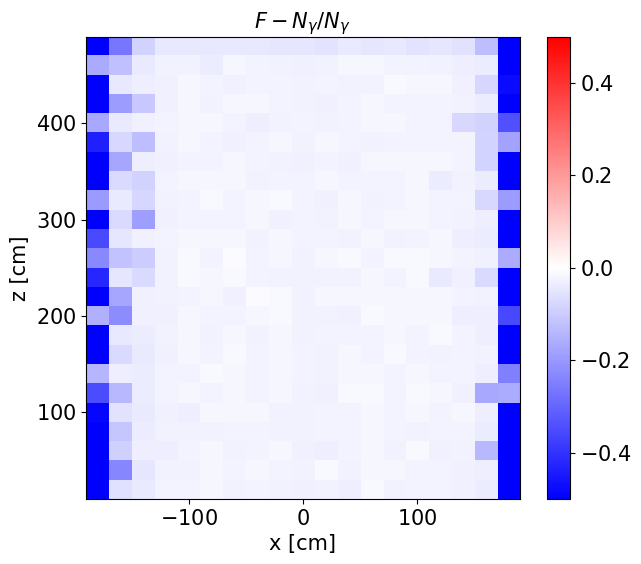

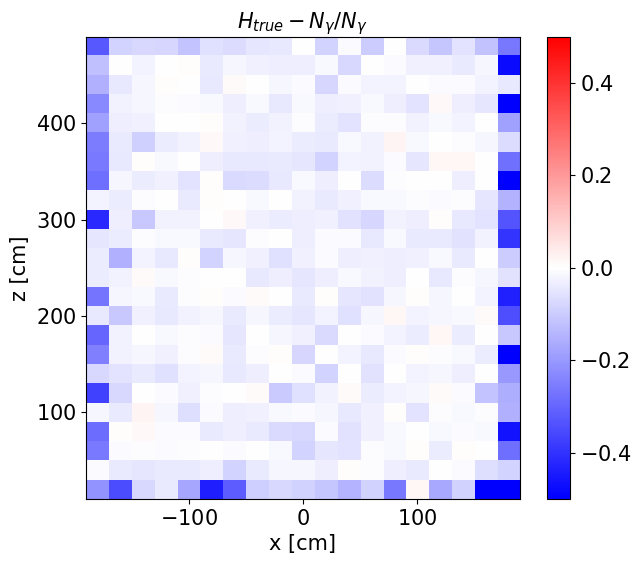

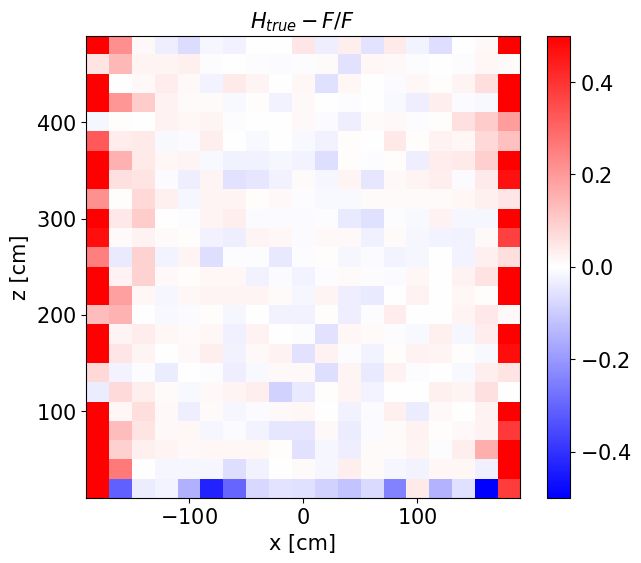

In [133]:
# Calculate errors
# location_df['error_flash'] = (location_df['flash_pe_mean'] - location_df['true_photons_mean']) / location_df['true_photons_mean']
# location_df['error_truth_hypo'] = (location_df['truth_hypo_pe_mean'] - location_df['true_photons_mean']) / location_df['true_photons_mean']
# location_df['error_reco_hypo'] = (location_df['reco_hypo_pe_mean'] - location_df['true_photons_mean']) / location_df['true_photons_mean']
true_flash_err = (location_df['truth_hypo_pe_mean'] - location_df['flash_pe_mean']) / location_df['flash_pe_mean']
# Define the grid
x_edges = np.unique(location_df.x)
y_edges = np.unique(location_df.z)

# Create 2D histograms for errors
H_flash, _, _ = np.histogram2d(location_df['x'], location_df['z'], bins=[x_edges, y_edges], weights=location_df['error_flash'])
H_truth_hypo, _, _ = np.histogram2d(location_df['x'], location_df['z'], bins=[x_edges, y_edges], weights=location_df['error_truth_hypo'])
H_flash_truth_hypo, _, _ = np.histogram2d(location_df['x'], location_df['z'], bins=[x_edges, y_edges], weights=true_flash_err)

fig, ax = plt.subplots(figsize=(7, 6))

# Plotting
cmap = 'bwr'  # Color map
vmin = -0.5
vmax = 0.5
im = ax.imshow(H_flash.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=ax)
ax.set_title('$F - N_\gamma / N_\gamma$')
ax.set_xlabel('x [cm]')
ax.set_ylabel('z [cm]')
plotters.save_plot(f'flash_true_err', folder_name=PLOT_DIR+'/location/2d')
#plt.close('all')

fig, ax = plt.subplots(figsize=(7, 6))

im = ax.imshow(H_truth_hypo.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=ax)
ax.set_title(r'$H_{true} - N_\gamma / N_\gamma$')
ax.set_xlabel('x [cm]')
ax.set_ylabel('z [cm]')

plotters.save_plot(f'true_hypo_true_err', folder_name=PLOT_DIR+'/location/2d')
#plt.close('all')

fig, ax = plt.subplots(figsize=(7, 6))

im = ax.imshow(H_flash_truth_hypo.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=ax)
ax.set_title(r'$H_{true} - F / F$')
ax.set_xlabel('x [cm]')
ax.set_ylabel('z [cm]')

plotters.save_plot(f'true_hypo_flash_err', folder_name=PLOT_DIR+'/location/2d')
#plt.close('all')

# 6. Angle

In [74]:
angle_df.keys()

Index(['run', 'subrun', 'pdg', 'p', 'x', 'y', 'z', 'thetaxz', 'thetayz', 't',
       'event_mean', 'event_std', 'true_photons_mean', 'true_photons_std',
       'flash_pe_mean', 'flash_pe_std', 'reco_hypo_pe_mean',
       'reco_hypo_pe_std', 'g4_hypo_pe_mean', 'g4_hypo_pe_std',
       'truth_hypo_pe_mean', 'truth_hypo_pe_std', 'g4_depo_mean',
       'g4_depo_std', 'truth_depo_mean', 'truth_depo_std', 'reco_depo_mean',
       'reco_depo_std', 'flash_to_true_photon_ratio',
       'flash_to_true_photon_ratio_err', 'truth_hypo_to_true_photon_ratio',
       'truth_hypo_to_true_photon_ratio_err', 'reco_hypo_to_true_photon_ratio',
       'reco_hypo_to_true_photon_ratio_err', 'truth_depo_to_g4_ratio',
       'truth_depo_to_g4_ratio_err', 'reco_depo_to_g4_ratio',
       'reco_depo_to_g4_ratio_err', 'error_flash', 'error_truth_hypo',
       'error_reco_hypo', 'error_truth_hypo_flash', 'error_reco_hypo_flash',
       'dummy_err', 'error_truth_depo', 'error_reco_depo'],
      dtype='object')

## 6.1 thetaxz

In [75]:
#What to plot
fname = 'light'
x_col = 'thetaxz'
y_cols = ['true_photons_mean','flash_pe_mean','truth_hypo_pe_mean','reco_hypo_pe_mean']
y_errs = ['true_photons_std','flash_pe_std','truth_hypo_pe_std','reco_hypo_pe_std']
labels = [r'$N_\gamma$', 'Flash', 'Truth Hypo', 'Reco Hypo']
colors = ['blue','green','orange','purple']

fname2 = 'depo'
y_cols2 = ['g4_depo_mean','truth_depo_mean','reco_depo_mean']
y_errs2 = ['g4_depo_std','truth_depo_std','reco_depo_std']
labels2 = ['G4 Depo','Truth Depo','Reco Depo']
colors2 = ['blue','orange','purple']

#Labels
xlabel = r'$\theta_{xz}$ [deg]'
ylabels = ('Light','Energy Deposited [MeV]')

#kwargs
alpha = 0.4
lw = 2
norms = [True,False]

#ax config
ylims = [0,1.2e5]
ylims2 = [0,1200]

#Save config
folder_name = PLOT_DIR+'/angle/linear/thetaxz'
save = True
close = True

for i,thetayz in tqdm(enumerate(np.unique(angle_df.thetayz))):
    #if thetayz != 0: continue
    
    #Set condition for plotting
    condition = angle_df.thetayz == thetayz
    

    #Conditional config
    fname_suffix = f'_thetayz{round(thetayz):.0f}'
    title = r'Particle Gun Muons ($p_\mu=1$ GeV $\theta_{yz}$ ' + f'= {round(thetayz)} deg)'
    
    plot_configurations(angle_df[condition], x_col, y_cols, y_errs, labels, colors, fname, y_cols2, y_errs2, labels2, colors2, title,
                        xlabel, ylabels, ylims, ylims2, fname2, folder_name=folder_name, save=save, close=close, fname_suffix=fname_suffix,
                        norms=norms,alpha=alpha,lw=lw)


0it [00:00, ?it/s]

In [76]:
#What to plot
fname = 'light'
x_col = 'thetaxz'
y_cols = ['flash_to_true_photon_ratio','truth_hypo_to_true_photon_ratio','reco_hypo_to_true_photon_ratio']
y_errs = ['flash_to_true_photon_ratio_err','truth_hypo_to_true_photon_ratio_err','reco_hypo_to_true_photon_ratio_err']
labels = [r'Flash/$N_\gamma$', r'Truth Hypo/$N_\gamma$', r'Reco Hypo/$N_\gamma$']
colors = ['green','orange','purple']

y_cols2 = ['truth_depo_to_g4_ratio','reco_depo_to_g4_ratio']
y_errs2 = ['truth_depo_to_g4_ratio_err','reco_depo_to_g4_ratio_err']
labels2 = ['Truth/G4','Reco/G4']
colors2 = ['orange','purple']

#Labels
xlabel = r'$\theta_{xz}$ [deg]'
ylabels = ('Light','Energy Deposited [MeV]')

#kwargs
alpha = 0.4
lw = 2
norms = [True,False]

#ax config
ylims = [0,1.2]
ylims2 = [0,1.2]

#Save config
folder_name = PLOT_DIR+'/angle/ratio/thetaxz'
save = True
close = True

for i,thetayz in tqdm(enumerate(np.unique(angle_df.thetayz))):
    #if thetayz != 0: continue
    
    #Set condition for plotting
    condition = angle_df.thetayz == thetayz
    

    #Conditional config
    fname_suffix = f'_thetayz{round(thetayz):.0f}'
    title = r'Particle Gun Muons ($p_\mu=1$ GeV $\theta_{yz}$ ' + f'= {round(thetayz)} deg)'
    
    plot_configurations(angle_df[condition], x_col, y_cols, y_errs, labels, colors, fname, y_cols2, y_errs2, labels2, colors2, title,
                        xlabel, ylabels, ylims, ylims2, fname2, folder_name=folder_name, save=save, close=close, fname_suffix=fname_suffix,
                        norms=norms,alpha=alpha,lw=lw)


0it [00:00, ?it/s]

In [92]:
#What to plot
fname = 'light'
x_col = 'thetaxz'
y_cols = ['error_flash','error_truth_hypo','error_reco_hypo','error_truth_hypo_flash','error_reco_hypo_flash']
y_errs = ['dummy_err']*len(y_cols)
labels = [r'F - $N_\gamma$ / $N_\gamma$', r'H$_{true}$ - $N_\gamma$ / $N_\gamma$', r'H$_{reco}$ - $N_\gamma$ / $N_\gamma$',r'H$_{true}$ - F / F', r'H$_{reco}$ - F / F']
colors = ['green','orange','purple','red','magenta']

fname2 = 'depo'
y_cols2 = ['error_truth_depo','error_reco_depo']
y_errs2 = ['dummy_err']*2
labels2 = [r'T - G4 / G4','R - G4 / G4']
colors2 = ['orange','purple']

#Labels
xlabel = r'$\theta_{xz}$ [deg]'
ylabels = ('Light','Energy Deposited [MeV]')

#kwargs
alpha = 0.4
lw = 2
norms = [False]

#ax config
ylims = [-0.5,0.5]
ylims2 = [-0.5,0.5]

#Save config
folder_name = PLOT_DIR+'/angle/error/thetaxz'
save = True
close = True

for i,thetayz in tqdm(enumerate(np.unique(angle_df.thetayz))):
    #print(thetayz)
    #if thetayz != -10: continue
    
    #Set condition for plotting
    condition = angle_df.thetayz == thetayz
    

    #Conditional config
    fname_suffix = f'_thetayz{round(thetayz):.0f}'
    title = r'Particle Gun Muons ($p_\mu=1$ GeV $\theta_{yz}$ ' + f'= {round(thetayz)} deg)'
    
    plot_configurations(angle_df[condition], x_col, y_cols, y_errs, labels, colors, fname, y_cols2, y_errs2, labels2, colors2, title,
                        xlabel, ylabels, ylims, ylims2, fname2, folder_name=folder_name, save=save, close=close, fname_suffix=fname_suffix,
                        norms=norms,alpha=alpha,lw=lw)


0it [00:00, ?it/s]

## 6.2 thetayz

In [78]:
#What to plot
fname = 'light'
x_col = 'thetayz'
y_cols = ['true_photons_mean','flash_pe_mean','truth_hypo_pe_mean','reco_hypo_pe_mean']
y_errs = ['true_photons_std','flash_pe_std','truth_hypo_pe_std','reco_hypo_pe_std']
labels = [r'$N_\gamma$', 'Flash', 'Truth Hypo', 'Reco Hypo']
colors = ['blue','green','orange','purple']

fname2 = 'depo'
y_cols2 = ['g4_depo_mean','truth_depo_mean','reco_depo_mean']
y_errs2 = ['g4_depo_std','truth_depo_std','reco_depo_std']
labels2 = ['G4 Depo','Truth Depo','Reco Depo']
colors2 = ['blue','orange','purple']

#Labels
xlabel = r'$\theta_{yz}$ [deg]'
ylabels = ('Light','Energy Deposited [MeV]')

#kwargs
alpha = 0.4
lw = 2
norms = [True,False]

#ax config
ylims = [0,1.2e5]
ylims2 = [0,1200]

#Save config
folder_name = PLOT_DIR+'/angle/linear/thetayz'
save = True
close = True

for i,thetaxz in tqdm(enumerate(np.unique(angle_df.thetaxz))):
    #if thetaxz != 0: continue
    
    #Set condition for plotting
    condition = angle_df.thetaxz == thetaxz
    

    #Conditional config
    fname_suffix = f'_thetayz{round(thetaxz):.0f}'
    title = r'Particle Gun Muons ($p_\mu=1$ GeV $\theta_{xz}$ ' + f'= {round(thetaxz)} deg)'
    
    plot_configurations(angle_df[condition], x_col, y_cols, y_errs, labels, colors, fname, y_cols2, y_errs2, labels2, colors2, title,
                        xlabel, ylabels, ylims, ylims2, fname2, folder_name=folder_name, save=save, close=close, fname_suffix=fname_suffix,
                        norms=norms,alpha=alpha,lw=lw)


0it [00:00, ?it/s]

In [79]:
#What to plot
fname = 'light'
x_col = 'thetayz'
y_cols = ['flash_to_true_photon_ratio','truth_hypo_to_true_photon_ratio','reco_hypo_to_true_photon_ratio']
y_errs = ['flash_to_true_photon_ratio_err','truth_hypo_to_true_photon_ratio_err','reco_hypo_to_true_photon_ratio_err']
labels = [r'Flash/$N_\gamma$', r'Truth Hypo/$N_\gamma$', r'Reco Hypo/$N_\gamma$']
colors = ['green','orange','purple']

fname2 = 'depo'
y_cols2 = ['truth_depo_to_g4_ratio','reco_depo_to_g4_ratio']
y_errs2 = ['truth_depo_to_g4_ratio_err','reco_depo_to_g4_ratio_err']
labels2 = ['Truth/G4','Reco/G4']
colors2 = ['orange','purple']

#Labels
xlabel = r'$\theta_{yz}$ [deg]'
ylabels = ('Light','Energy Deposited [MeV]')

#kwargs
alpha = 0.4
lw = 2
norms = [True,False]

#ax config
ylims = [0,1.2]
ylims2 = [0,1.2]

#Save config
folder_name = PLOT_DIR+'/angle/ratio/thetayz'
save = True
close = True

for i,thetaxz in tqdm(enumerate(np.unique(angle_df.thetaxz))):
    #if thetaxz != 0: continue
    
    #Set condition for plotting
    condition = angle_df.thetaxz == thetaxz
    

    #Conditional config
    fname_suffix = f'_thetayz{round(thetaxz):.0f}'
    title = r'Particle Gun Muons ($p_\mu=1$ GeV $\theta_{xz}$ ' + f'= {round(thetaxz)} deg)'
    
    plot_configurations(angle_df[condition], x_col, y_cols, y_errs, labels, colors, fname, y_cols2, y_errs2, labels2, colors2, title,
                        xlabel, ylabels, ylims, ylims2, fname2, folder_name=folder_name, save=save, close=close, fname_suffix=fname_suffix,
                        norms=norms,alpha=alpha,lw=lw)


0it [00:00, ?it/s]

In [93]:
#What to plot
fname = 'light'
x_col = 'thetayz'
y_cols = ['error_flash','error_truth_hypo','error_reco_hypo','error_truth_hypo_flash','error_reco_hypo_flash']
y_errs = ['dummy_err']*len(y_cols)
labels = [r'F - $N_\gamma$ / $N_\gamma$', r'H$_{true}$ - $N_\gamma$ / $N_\gamma$', r'H$_{reco}$ - $N_\gamma$ / $N_\gamma$',r'H$_{true}$ - F / F', r'H$_{reco}$ - F / F']
colors = ['green','orange','purple','red','magenta']

fname2 = 'depo'
y_cols2 = ['error_truth_depo','error_reco_depo']
y_errs2 = ['dummy_err']*2
labels2 = [r'T - G4 / G4','R - G4 / G4']
colors2 = ['orange','purple']

#Labels
xlabel = r'$\theta_{yz}$ [deg]'
ylabels = ('Light','Energy Deposited [MeV]')

#kwargs
alpha = 0.4
lw = 2
norms = [False]

#ax config
ylims = [-0.5,0.5]
ylims2 = [-0.5,0.5]

#Save config
folder_name = PLOT_DIR+'/angle/error/thetayz'
save = True
close = True

for i,thetaxz in tqdm(enumerate(np.unique(angle_df.thetaxz))):
    #if thetaxz != 0: continue
    
    #Set condition for plotting
    condition = angle_df.thetaxz == thetaxz
    

    #Conditional config
    fname_suffix = f'_thetayz{round(thetaxz):.0f}'
    title = r'Particle Gun Muons ($p_\mu=1$ GeV $\theta_{xz}$ ' + f'= {round(thetaxz)} deg)'
    
    plot_configurations(angle_df[condition], x_col, y_cols, y_errs, labels, colors, fname, y_cols2, y_errs2, labels2, colors2, title,
                        xlabel, ylabels, ylims, ylims2, fname2, folder_name=folder_name, save=save, close=close, fname_suffix=fname_suffix,
                        norms=norms,alpha=alpha,lw=lw)


0it [00:00, ?it/s]

## 6.3 2d

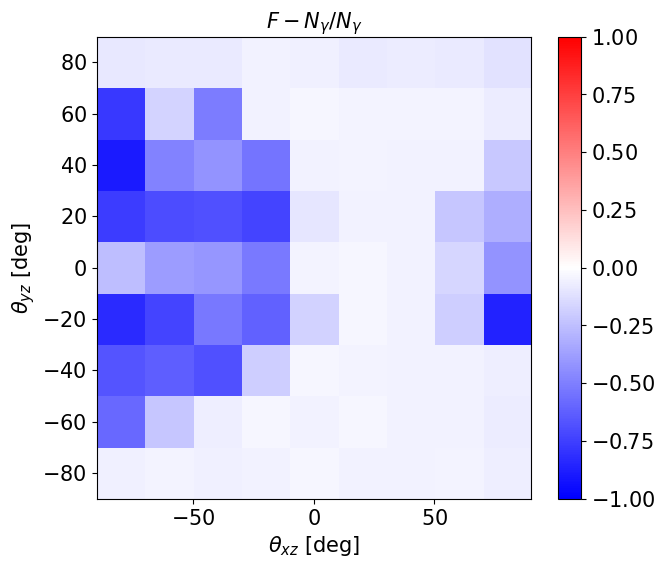

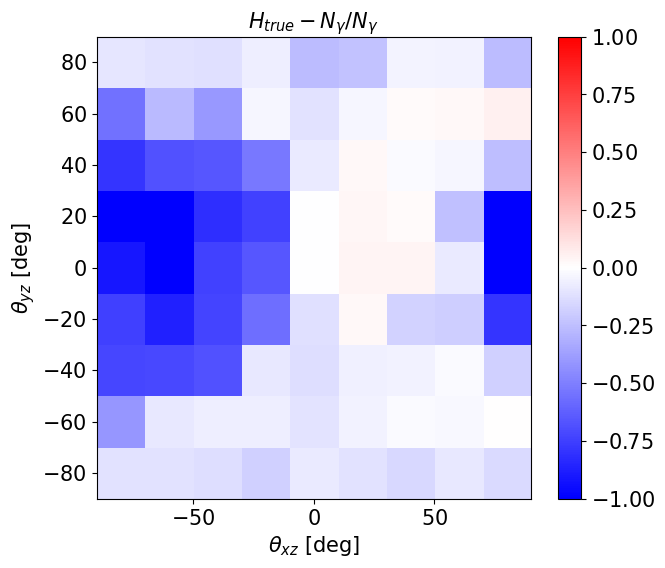

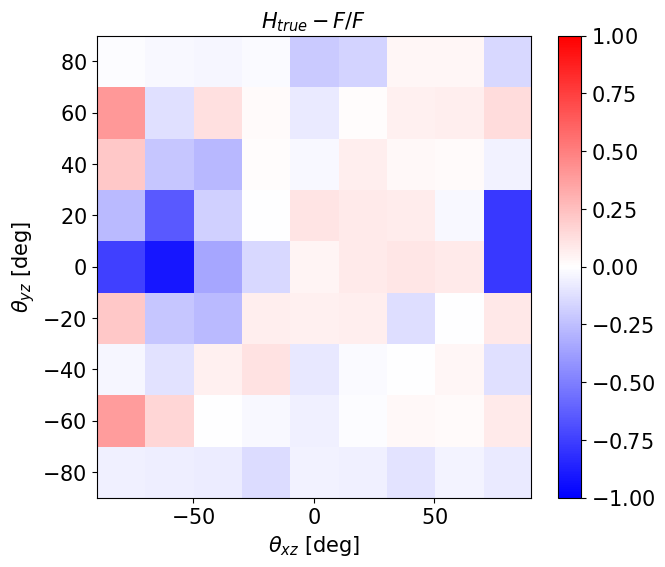

In [137]:
# Calculate errors

true_flash_err = (angle_df['truth_hypo_pe_mean'] - angle_df['flash_pe_mean']) / angle_df['flash_pe_mean']
# Define the grid
x_edges = np.unique(angle_df.thetaxz)[::2]
y_edges = np.unique(angle_df.thetayz)[::2]

# Create 2D histograms for errors
H_flash, _, _ = np.histogram2d(angle_df['thetaxz'], angle_df['thetayz'], bins=[x_edges, y_edges], weights=angle_df['error_flash'])
H_truth_hypo, _, _ = np.histogram2d(angle_df['thetaxz'], angle_df['thetayz'], bins=[x_edges, y_edges], weights=angle_df['error_truth_hypo'])
H_flash_truth_hypo, _, _ = np.histogram2d(angle_df['thetaxz'], angle_df['thetayz'], bins=[x_edges, y_edges], weights=true_flash_err)

fig, ax = plt.subplots(figsize=(7, 6))

# Plotting
cmap = 'bwr'  # Color map
vmin = -1
vmax = 1
im = ax.imshow(H_flash.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=ax)
ax.set_title('$F - N_\gamma / N_\gamma$')
ax.set_xlabel(r'$\theta_{xz}$ [deg]')
ax.set_ylabel(r'$\theta_{yz}$ [deg]')
plotters.save_plot(f'flash_true_err', folder_name=PLOT_DIR+'/angle/2d')
#plt.close('all')

fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(H_truth_hypo.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=ax)
ax.set_title('$H_{true} - N_\gamma / N_\gamma$')
ax.set_xlabel(r'$\theta_{xz}$ [deg]')
ax.set_ylabel(r'$\theta_{yz}$ [deg]')
plotters.save_plot(f'true_hypo_true_err', folder_name=PLOT_DIR+'/angle/2d')
#plt.close('all')

fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(H_flash_truth_hypo.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=ax)
ax.set_title('$H_{true} - F / F$')
ax.set_xlabel(r'$\theta_{xz}$ [deg]')
ax.set_ylabel(r'$\theta_{yz}$ [deg]')
plotters.save_plot(f'true_hypo_flash_err', folder_name=PLOT_DIR+'/angle/2d')
#plt.close('all')

# 7. Particle

In [82]:
particle_df

,run,subrun,pdg,p,x,y,z,thetaxz,thetayz,t,...,reco_depo_to_g4_ratio,reco_depo_to_g4_ratio_err,error_flash,error_truth_hypo,error_reco_hypo,error_truth_hypo_flash,error_reco_hypo_flash,dummy_err,error_truth_depo,error_reco_depo
700,3000,0,13,1.0,-100.0,0.0,0.0,0.0,0.0,0.0,...,0.998804,0.020536,-0.017032,0.008150,-0.071211,0.025618,-0.055118,0,0.081191,-0.001196
701,3001,0,22,1.0,-100.0,0.0,0.0,0.0,0.0,0.0,...,0.669920,0.027092,-0.029569,-0.223561,-0.326767,-0.199903,-0.306254,0,-0.232719,-0.330080
702,3002,0,11,1.0,-100.0,0.0,0.0,0.0,0.0,0.0,...,0.660691,0.044609,-0.031325,-0.239644,-0.333258,-0.215056,-0.311697,0,-0.246273,-0.339309
703,3003,0,211,1.0,-100.0,0.0,0.0,0.0,0.0,0.0,...,0.726207,0.212796,-0.090645,-0.386834,-0.537022,-0.325714,-0.490872,0,-0.045679,-0.273793
704,3004,0,2212,1.0,-100.0,0.0,0.0,0.0,0.0,0.0,...,0.705547,0.180984,-0.034200,-0.286429,-0.467501,-0.261160,-0.448645,0,-0.072829,-0.294453


In [83]:
pdgs = [str(p) for p in particle_df.pdg]
pdg_names = [r'$\mu$',r'$\gamma$',r'$e$',r'$\pi$',r'$p$']
_x = np.arange(0,len(pdgs))
_x,pdgs,pdg_names

(array([0, 1, 2, 3, 4]),
 ['13', '22', '11', '211', '2212'],
 ['$\\mu$', '$\\gamma$', '$e$', '$\\pi$', '$p$'])

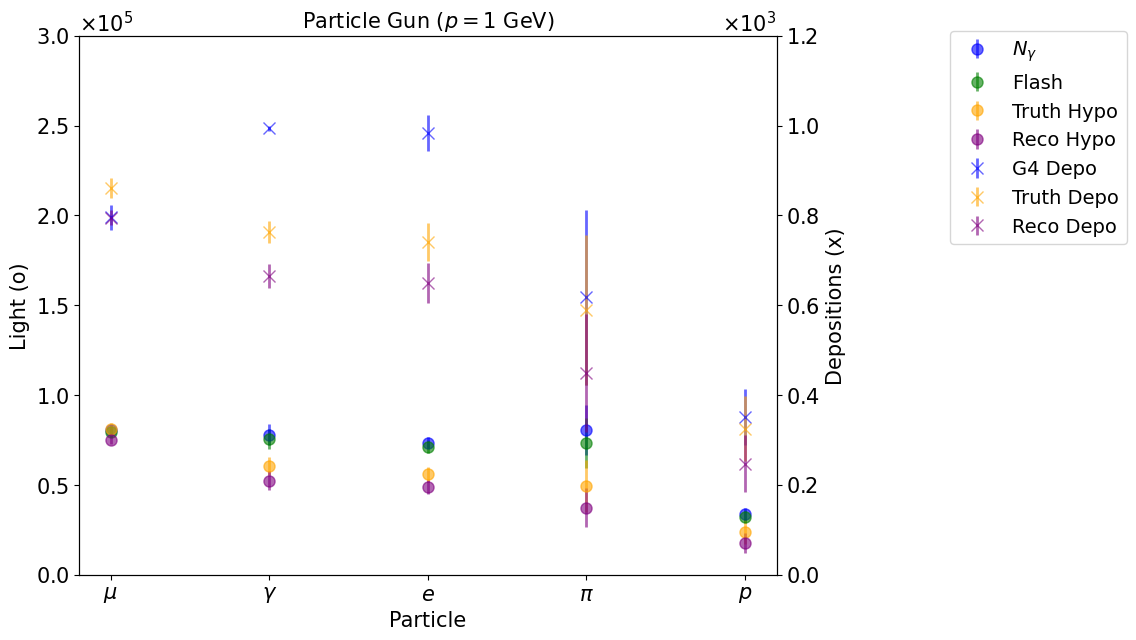

In [85]:
alpha = 0.6

fig,ax = plt.subplots(figsize=(9,7))
ax2 = ax.twinx()

#Condition to limit
condition = [True]*len(particle_df)

#Truth photons
ax.errorbar(_x,
            particle_df[condition].true_photons_mean,
            particle_df[condition].true_photons_std,
            alpha=alpha,
            marker='o',
            ls='',
           label=r'$N_\gamma$',
           color='blue')

#Flash
ax.errorbar(_x,
            particle_df[condition].flash_pe_mean,
            particle_df[condition].flash_pe_std,
            alpha=alpha,
            marker='o',
            ls='',
           label='Flash',
           color='green')

#Hypothesis from truth interactions
ax.errorbar(_x,
            particle_df[condition].truth_hypo_pe_mean,
            particle_df[condition].truth_hypo_pe_std,
            alpha=alpha,
            marker='o',
            ls='',
           label='Truth Hypo',
           color='orange')
#Hypothesis from reco interactions
ax.errorbar(_x,
            particle_df[condition].reco_hypo_pe_mean,
            particle_df[condition].reco_hypo_pe_std,
            alpha=alpha,
            marker='o',
            ls='',
           label='Reco Hypo',
           color='purple')

#G4 depositions
ax2.errorbar(_x,
             particle_df[condition].g4_depo_mean,
            particle_df[condition].g4_depo_std,
             alpha=alpha,
             marker='x',
             ls='',
             label='G4 Depo',
            color='blue')
#Truth depositions
ax2.errorbar(_x,
             particle_df[condition].truth_depo_mean,
            particle_df[condition].truth_depo_std,
             alpha=alpha,
             marker='x',
             ls='',
             label='Truth Depo',
            color='orange')
#Reco depositions
ax2.errorbar(_x,
             particle_df[condition].reco_depo_mean,
             particle_df[condition].reco_depo_std,
             alpha=alpha,
             marker='x',
             ls='',
             #markersize=8,
             label='Reco Depo',
            color='purple')

# Get handles and labels from both axes
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
handles = handles1 + handles2
labels = labels1 + labels2

# Create one legend with all handles and labels
fig.legend(handles, labels, bbox_to_anchor=(1.3, 0.9), fontsize=14)

ax.set_xlabel(r'Particle')
ax.set_ylabel('Light (o)')
ax2.set_ylabel('Depositions (x)')
ax.set_title(r'Particle Gun ($p=1$ GeV)')
#ax.set_xticklabels(pdgs)
plt.xticks(_x, pdg_names)  # Set the tick positions and labels

#Constrain limits
ax.set_ylim(0,3e5)
ax2.set_ylim(0,1200)

plotters.save_plot(f'depostions_light',folder_name=PLOT_DIR+'/particle')

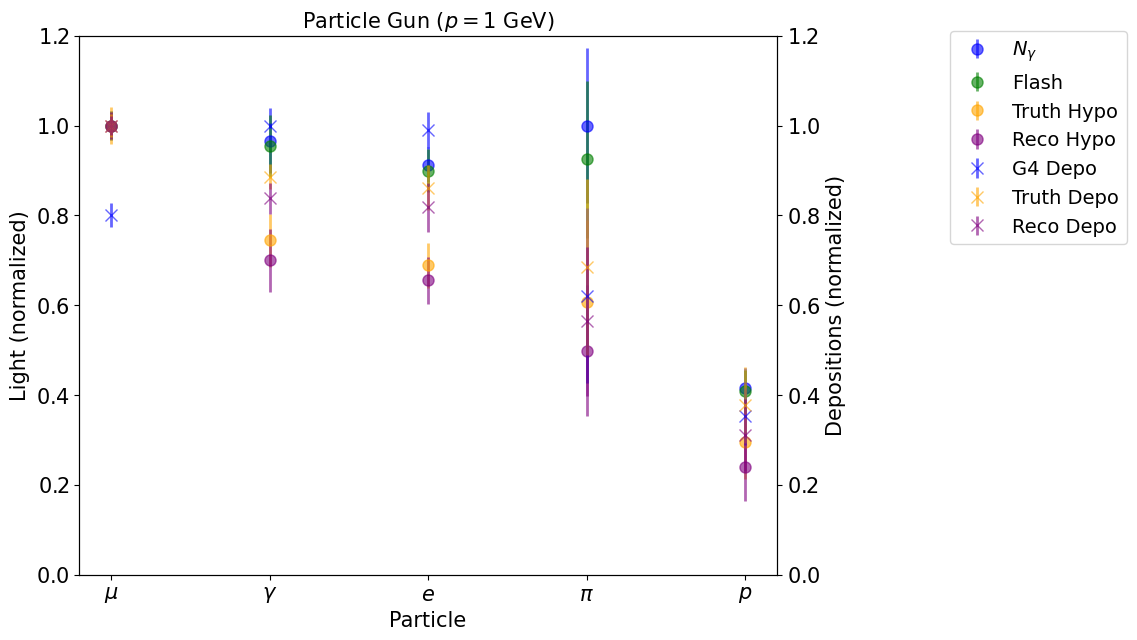

In [86]:
alpha = 0.6

fig,ax = plt.subplots(figsize=(9,7))
ax2 = ax.twinx()

#Condition to limit
condition = [True]*len(particle_df)

#Truth photons
ax.errorbar(_x,
            particle_df[condition].true_photons_mean/np.max(particle_df[condition].true_photons_mean),
            particle_df[condition].true_photons_std/np.max(particle_df[condition].true_photons_mean),
            alpha=alpha,
            marker='o',
            ls='',
           label=r'$N_\gamma$',
           color='blue')

#Flash
ax.errorbar(_x,
            particle_df[condition].flash_pe_mean/np.max(particle_df[condition].flash_pe_mean),
            particle_df[condition].flash_pe_std/np.max(particle_df[condition].flash_pe_mean),
            alpha=alpha,
            marker='o',
            ls='',
           label='Flash',
           color='green')

#Hypothesis from truth interactions
ax.errorbar(_x,
            particle_df[condition].truth_hypo_pe_mean/np.max(particle_df[condition].truth_hypo_pe_mean),
            particle_df[condition].truth_hypo_pe_std/np.max(particle_df[condition].truth_hypo_pe_mean),
            alpha=alpha,
            marker='o',
            ls='',
           label='Truth Hypo',
           color='orange')
#Hypothesis from reco interactions
ax.errorbar(_x,
            particle_df[condition].reco_hypo_pe_mean/np.max(particle_df[condition].reco_hypo_pe_mean),
            particle_df[condition].reco_hypo_pe_std/np.max(particle_df[condition].reco_hypo_pe_mean),
            alpha=alpha,
            marker='o',
            ls='',
           label='Reco Hypo',
           color='purple')

#G4 depositions
ax2.errorbar(_x,
             particle_df[condition].g4_depo_mean/np.max(particle_df[condition].g4_depo_mean),
            particle_df[condition].g4_depo_std/np.max(particle_df[condition].g4_depo_mean),
             alpha=alpha,
             marker='x',
             ls='',
             label='G4 Depo',
            color='blue')
#Truth depositions
ax2.errorbar(_x,
             particle_df[condition].truth_depo_mean/np.max(particle_df[condition].truth_depo_mean),
            particle_df[condition].truth_depo_std/np.max(particle_df[condition].truth_depo_mean),
             alpha=alpha,
             marker='x',
             ls='',
             label='Truth Depo',
            color='orange')
#Reco depositions
ax2.errorbar(_x,
             particle_df[condition].reco_depo_mean/np.max(particle_df[condition].reco_depo_mean),
             particle_df[condition].reco_depo_std/np.max(particle_df[condition].reco_depo_mean),
             alpha=alpha,
             marker='x',
             ls='',
             #markersize=8,
             label='Reco Depo',
            color='purple')

# Get handles and labels from both axes
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
handles = handles1 + handles2
labels = labels1 + labels2

# Create one legend with all handles and labels
fig.legend(handles, labels, bbox_to_anchor=(1.3, 0.9), fontsize=14)

ax.set_xlabel(r'Particle')
ax.set_ylabel('Light (normalized)')
ax2.set_ylabel('Depositions (normalized)')
ax.set_title(r'Particle Gun ($p=1$ GeV)')
#ax.set_xticklabels(pdgs)
plt.xticks(_x, pdg_names)  # Set the tick positions and labels

#Constrain limits
ax.set_ylim(0,1.2)
ax2.set_ylim(0,1.2)

plotters.save_plot(f'depostions_light_norm',folder_name=PLOT_DIR+'/particle')

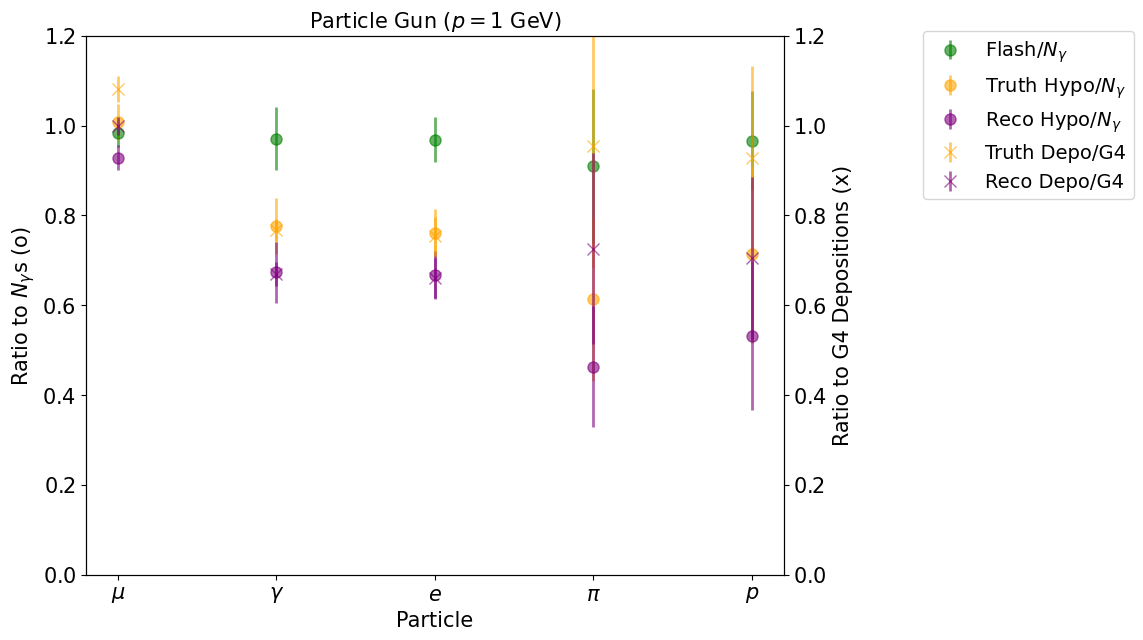

In [88]:
alpha = 0.6

fig,ax = plt.subplots(figsize=(9,7))
ax2 = ax.twinx()

#Condition to limit
condition = [True]*len(particle_df)

# Plotting ratios with error bars
ax.errorbar(_x, particle_df[condition].flash_to_true_photon_ratio, 
            yerr=particle_df[condition].flash_to_true_photon_ratio_err,
            alpha=alpha,marker='o',
             ls='', label=r'Flash/$N_\gamma$',
           color='green')
ax.errorbar(_x, particle_df[condition].truth_hypo_to_true_photon_ratio,
            yerr=particle_df[condition].truth_hypo_to_true_photon_ratio_err,
            alpha=alpha,marker='o',
             ls='', label=r'Truth Hypo/$N_\gamma$',
           color='orange')
ax.errorbar(_x, particle_df[condition].reco_hypo_to_true_photon_ratio,
            yerr=particle_df[condition].reco_hypo_to_true_photon_ratio_err,
            alpha=alpha,marker='o',
             ls='', label=r'Reco Hypo/$N_\gamma$',
           color='purple')

ax2.errorbar(_x, particle_df[condition].truth_depo_to_g4_ratio, 
             yerr=particle_df[condition].truth_depo_to_g4_ratio_err,
             alpha=alpha, marker='x',
             ls='', label='Truth Depo/G4',
            color='orange')
ax2.errorbar(_x, particle_df[condition].reco_depo_to_g4_ratio,
             yerr=particle_df[condition].reco_depo_to_g4_ratio_err,
             alpha=alpha, marker='x',
             ls='', label='Reco Depo/G4',
            color='purple')

# Get handles and labels from both axes
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
handles = handles1 + handles2
labels = labels1 + labels2

# Create one legend with all handles and labels
fig.legend(handles, labels, bbox_to_anchor=(1.3, 0.9), fontsize=14)

ax.set_xlabel(r'Particle')
ax.set_ylabel(r'Ratio to $N_\gamma$s (o)')
ax2.set_ylabel('Ratio to G4 Depositions (x)')
ax.set_title(r'Particle Gun ($p=1$ GeV)')
#ax.set_xticklabels(pdgs)
plt.xticks(_x, pdg_names)  # Set the tick positions and labels

#Constrain limits
ax.set_ylim(0,1.2)
ax2.set_ylim(0,1.2)

plotters.save_plot(f'ratio',folder_name=PLOT_DIR+'/particle')

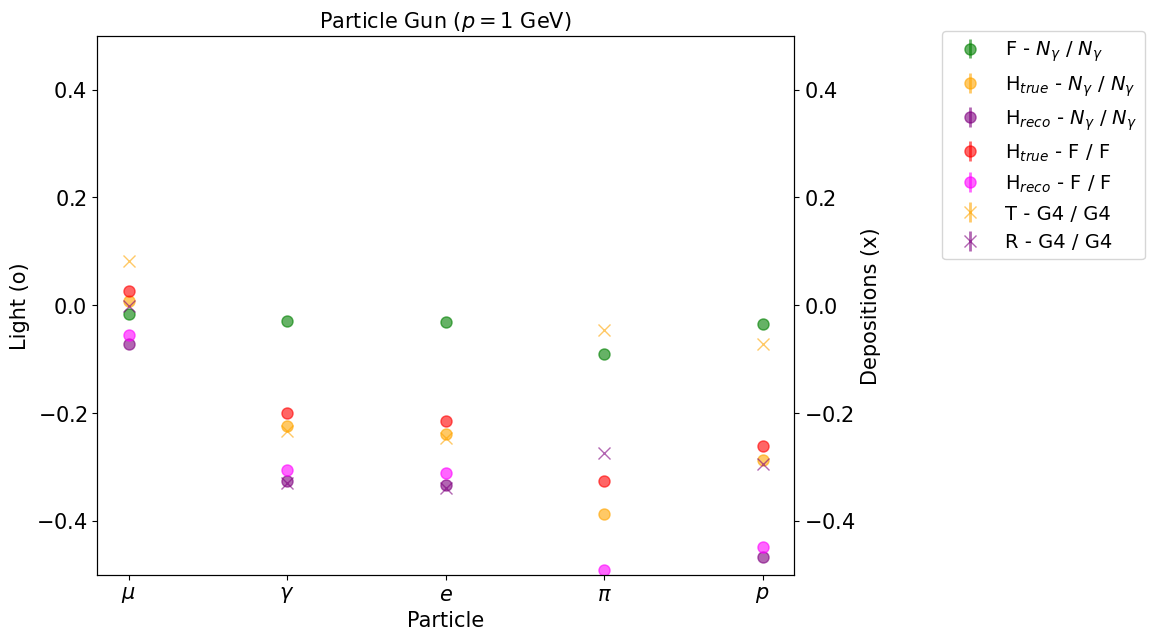

In [94]:
#y_cols = ['error_flash','error_truth_hypo','error_reco_hypo']
# y_errs = ['dummy_err']*3
# labels = [r'F - $N_\gamma$ / $N_\gamma$', r'H$_{true}$ - $N_\gamma$ / $N_\gamma$', r'H$_{reco}$ - $N_\gamma$ / $N_\gamma$']
# colors = ['green','orange','purple']

# fname2 = 'depo'
# y_cols2 = ['error_truth_depo','error_reco_depo']
# y_errs2 = ['dummy_err']*2
# labels2 = [r'T - G4 / G4','R - G4 / G4']
# colors2 = ['orange','purple']

alpha = 0.6

fig,ax = plt.subplots(figsize=(9,7))
ax2 = ax.twinx()

#Condition to limit
condition = [True]*len(particle_df)

# Plotting ratios with error bars
ax.errorbar(_x, particle_df[condition].error_flash, 
            yerr=particle_df[condition].dummy_err,
            alpha=alpha,marker='o',
             ls='', label=r'F - $N_\gamma$ / $N_\gamma$',
           color='green')
ax.errorbar(_x, particle_df[condition].error_truth_hypo,
            yerr=particle_df[condition].dummy_err,
            alpha=alpha,marker='o',
             ls='', label=r'H$_{true}$ - $N_\gamma$ / $N_\gamma$',
           color='orange')
ax.errorbar(_x, particle_df[condition].error_reco_hypo,
            yerr=particle_df[condition].dummy_err,
            alpha=alpha,marker='o',
             ls='', label=r'H$_{reco}$ - $N_\gamma$ / $N_\gamma$',
           color='purple')
ax.errorbar(_x, particle_df[condition].error_truth_hypo_flash,
            yerr=particle_df[condition].dummy_err,
            alpha=alpha,marker='o',
             ls='', label=r'H$_{true}$ - F / F',
           color='red')
ax.errorbar(_x, particle_df[condition].error_reco_hypo_flash,
            yerr=particle_df[condition].dummy_err,
            alpha=alpha,marker='o',
             ls='', label=r'H$_{reco}$ - F / F',
           color='magenta')

ax2.errorbar(_x, particle_df[condition].error_truth_depo, 
             yerr=particle_df[condition].dummy_err,
             alpha=alpha, marker='x',
             ls='', label=r'T - G4 / G4',
            color='orange')
ax2.errorbar(_x, particle_df[condition].error_reco_depo,
             yerr=particle_df[condition].dummy_err,
             alpha=alpha, marker='x',
             ls='', label=r'R - G4 / G4',
            color='purple')

# Get handles and labels from both axes
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
handles = handles1 + handles2
labels = labels1 + labels2

# Create one legend with all handles and labels
fig.legend(handles, labels, bbox_to_anchor=(1.3, 0.9), fontsize=14)

ax.set_xlabel(r'Particle')
ax.set_ylabel('Light (o)')
ax2.set_ylabel('Depositions (x)')
ax.set_title(r'Particle Gun ($p=1$ GeV)')
#ax.set_xticklabels(pdgs)
plt.xticks(_x, pdg_names)  # Set the tick positions and labels

#Constrain limits
ax.set_ylim(-0.5,0.5)
ax2.set_ylim(-0.5,0.5)

plotters.save_plot(f'error',folder_name=PLOT_DIR+'/particle')

# X. Single event tests

## X.0 Larcv reader

In [80]:
larcv_cfg = yaml.safe_load(open(LARCV_CFG_PATH, 'r'))
print(yaml.dump(larcv_cfg))

_larcv_driver = Driver(larcv_cfg)
larcv_data = _larcv_driver.process()
larcv_data.keys()

io:
  loader:
    batch_size: 4000
    collate_fn: all
    dataset:
      file_keys:
      - /sdf/data/neutrino/bearc/spine/fmatch/validation/energy/larcv/*.root
      - /sdf/data/neutrino/bearc/spine/fmatch/validation/location/larcv/larcv.root
      - /sdf/data/neutrino/bearc/spine/fmatch/validation/angle/larcv/larcv.root
      - /sdf/data/neutrino/bearc/spine/fmatch/validation/particle/larcv/*.root
      name: larcv
      schema:
        meta:
          parser: meta3d
          sparse_event: sparse3d_pcluster
        particles:
          cluster_event: cluster3d_pcluster
          neutrino_event: neutrino_mpv
          parser: particle
          particle_event: particle_corrected
        run_info:
          parser: run_info
          sparse_event: sparse3d_pcluster
    num_workers: 8
    shuffle: false


 ██████████   ██████████    ███   ███       ██   ███████████
███        █  ██       ███   █    █████     ██   ██         
  ████████    ██       ███  ███   ██  ████  ██   ██████████ 

dict_keys(['index', 'file_index', 'file_entry_index', 'particles', 'run_info', 'meta'])

In [85]:
print(larcv_data['particles'][2007][0].interaction_primary,
larcv_data['particles'][2007][0].momentum,
larcv_data['particles'][2007][0].position,
larcv_data['particles'][2007][0].end_position,
larcv_data['run_info'][2007])
#run_list = [r.run for r in larcv_data['run_info']]
#run_list.index(1001)
larcv_data['meta'][0].to_cm(larcv_data['particles'][2097][0].position)

1 [ 0.000000e+00 -1.000000e+03  6.123234e-14] [ 990.6667  1724.       491.33328] [959.8778  350.25558 638.4134 ] RunInfo(run=1001, subrun=0, event=1)


array([-109.999985,  210.      ,  410.      ], dtype=float32)

## X.1 Associate run info from .h5

In [107]:
from tqdm.notebook import tqdm
cfg = yaml.safe_load(open(CFG_PATH, 'r'))
print(yaml.dump(cfg))
    # print(min(df['distance'].values),#[0:5],
    #       min(df['momentum_diff'].values),#[0:5],
    #       min(df['pdg_diff'].values),#[0:5],
    #       min(df['thetaxz_diff'].values),#[0:5],
    #       min(df['thetayz_diff'].values))#[0:5])

_driver = Driver(cfg)
ENTRY = 50
data = _driver.process(entry=ENTRY)
#Get the particle configuration used for this run
run = data['run_info'].run
_run_info = run_info[run_info.run == run]

runs = []
findex = []
row_matches = []
for i in tqdm(range(len(_driver))):
#for i in tqdm(range(30)):
    _d = _driver.process(entry=i)
    runs.append(_d['run_info'].run)
    findex.append(_d['file_index'])

    tp = _d['truth_particles']
    tp_prim = [t for t in tp if t.is_primary]
    if len(tp_prim) > 1:
        print(f'wtf {i}')
    else:
        tp_prim = tp_prim[0]
    #print(tp_prim.start_point,tp_prim.momentum)
    #_,match = find_closest_particle(run_info,tp_prim)
    #row_matches.append(match)

build:
  fragments: false
  interactions: true
  mode: both
  particles: true
  units: cm
io:
  reader:
    file_keys:
    - /sdf/data/neutrino/bearc/spine/fmatch/validation/angle/output_spine/larcv_spine.h5
    name: hdf5


 ██████████   ██████████    ███   ███       ██   ███████████
███        █  ██       ███   █    █████     ██   ██         
  ████████    ██       ███  ███   ██  ████  ██   ██████████ 
█        ███  ██████████     █    ██     █████   ██         
 ██████████   ██            ███   ██       ███   ███████████

Release version: 0.1.0

$CUDA_VISIBLE_DEVICES=

Configuration processed at: Linux sdfampere023 4.18.0-372.32.1.el8_6.x86_64 #1 SMP Fri Oct 7 12:35:10 EDT 2022 x86_64 x86_64 x86_64 GNU/Linux

base: {seed: 1727899163}
io:
  reader:
    file_keys: [/sdf/data/neutrino/bearc/spine/fmatch/validation/angle/output_spine/larcv_spine.h5]
    name: hdf5
build: {fragments: false, interactions: true, mode: both, particles: true, units: cm}

Will load 1 file(s):
  - /sdf/data/ne

  0%|          | 0/543 [00:00<?, ?it/s]

In [110]:
len(np.unique(runs,return_counts=True)[0])

181

In [96]:
_d['points_g4'][0]

array([-100.05     ,   -0.4500122,    9.950005 ], dtype=float32)

In [111]:
run_info.keys()

Index(['run', 'filename', 'pdg', 'p', 'x', 'y', 'z', 'thetaxz', 'thetayz', 't',
       'distance', 'momentum_diff', 'pdg_diff', 'thetaxz_diff', 'thetayz_diff',
       'total_diff'],
      dtype='object')

In [12]:
data.keys()

dict_keys(['file_index', 'sources_label', 'flash_tpc1xa', 'points', 'sources', 'truth_interactions', 'depositions', 'depositions_g4', 'index', 'run_info', 'flash_tpc0xa', 'flash_tpc1', 'meta', 'reco_particles', 'depositions_label', 'reco_interactions', 'flash_tpc0', 'points_g4', 'points_label', 'depositions_q_label', 'truth_particles', 'particle_matches_r2t', 'particle_matches_r2t_overlap', 'particle_matches_t2r', 'particle_matches_t2r_overlap', 'interaction_matches_r2t', 'interaction_matches_r2t_overlap', 'interaction_matches_t2r', 'interaction_matches_t2r_overlap'])

In [13]:
data['flash_tpc0'][0].total_pe

86333.41632499993

In [14]:
tp = data['truth_particles'][0]
tp.depositions_sum,tp.depositions_g4_sum

(766.0834, 980.8241)

## X.2 Associate truth optical info with run

In [45]:
np.unique(df_nphot.runID,return_counts=True)

(array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
          12,   13,   14,   15,   16,   17,   18,   19,   20, 1000, 1001,
        1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012,
        1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023,
        1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034,
        1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045,
        1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056,
        1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067,
        1068, 1069, 1070, 1071, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
        2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
        2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028,
        2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039,
        2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050,
        2051, 2052, 2053, 2054, 2055, 

In [15]:
fname = _run_info.values[0][1]
#opana_fname = fname.replace('larcv','opana')
#opana_fname = '/sdf/data/neutrino/bearc/spine/fmatch/validation/angle/opana/opana_pdg13_P1.0_X-100_Y0_Z10_thetaxz-70_thetayz40_t0.root' 
opana_fname = '/sdf/data/neutrino/bearc/spine/fmatch/validation/angle/opana/opana_pdg13_P1.0_X-100_Y0_Z10_thetaxz-70_thetayz10_t0.root'
tree_opana = uproot.open(opana_fname)['opanatree/OpAnaTree;1']
#Manully get keys for different trees - constant so no need to redefine
keys_opana_run = ['eventID','runID','subrunID']
keys_opana_ntot = [k for k in tree_opana.keys() if 'NPhoton' in k]
#tree_opana.keys()
df_nphot = tree_opana.arrays(keys_opana_ntot + keys_opana_run,library='pd')
df_nphot.drop_duplicates(inplace=True)
df_nphot
#(df_nphot['runID'] == 2051) , (df_nphot['subrunID'] == 1) , (df_nphot['eventID'] == 1)
#_df_nphot = df_nphot[(df_nphot['runID'] == 2051) & (df_nphot['subrunID'] == 1) & (df_nphot['eventID'] == 1)]
#_df_nphot

,NPhotons,NPhotonsPMTCo,NPhotonsPMTUnco,NPhotonsPMTCoVUV,NPhotonsXARAPUCAVUV,NPhotonsXARAPUCAVIS,eventID,runID,subrunID
0,57732,56274,1458,50628,0,0,1,2048,0
1,52292,50994,1298,45883,0,0,2,2048,0
2,56271,55032,1239,50096,0,0,3,2048,0
3,53423,52068,1355,46645,0,0,4,2048,0
4,49494,48242,1252,43319,0,0,5,2048,0


## X.3 Flash match logs

In [15]:
basedir

'/sdf/data/neutrino/bearc/spine/fmatch/validation/energy'

In [20]:
g4_log_list = [f for f in os.listdir(basedir+'/g4_logs') if 'truth_interactions' in f]

In [ ]:
for i,_f in enumerate(fs):
    